In [1]:
# disable pycache
import sys
sys.dont_write_bytecode = True
from datetime import datetime
from pudu.apis.raw.gas_api import *
from pudu.apis.raw.pudu_api import *
from pudu.app.main import App
from pudu.rds import RDSTable
from pudu.rds.utils import *
from pudu.notifications.change_detector import *
from pudu.reporting import *

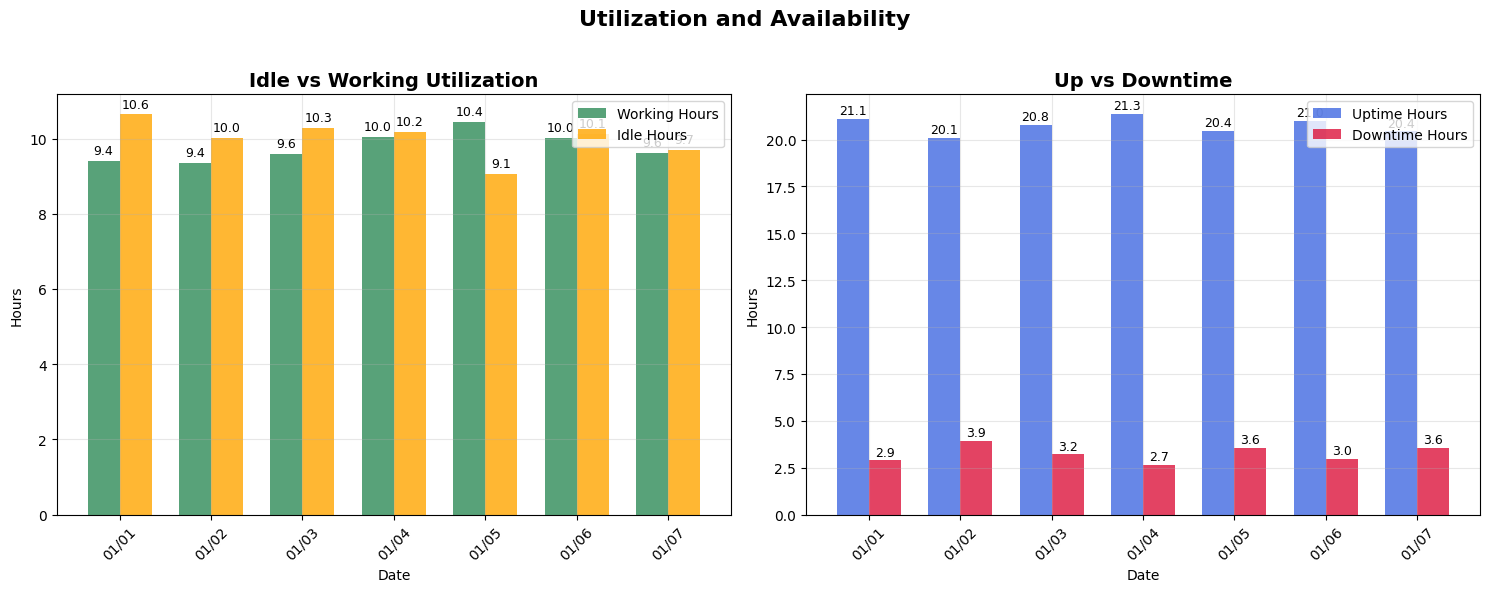

Daily Averages Summary:
2024-01-01:
  Utilization: 46.9% (Working: 9.4h, Idle: 10.6h)
  Availability: 88.0% (Up: 21.1h, Down: 2.9h)

2024-01-02:
  Utilization: 48.3% (Working: 9.4h, Idle: 10.0h)
  Availability: 83.7% (Up: 20.1h, Down: 3.9h)

2024-01-03:
  Utilization: 48.2% (Working: 9.6h, Idle: 10.3h)
  Availability: 86.6% (Up: 20.8h, Down: 3.2h)

2024-01-04:
  Utilization: 49.6% (Working: 10.0h, Idle: 10.2h)
  Availability: 88.9% (Up: 21.3h, Down: 2.7h)

2024-01-05:
  Utilization: 53.5% (Working: 10.4h, Idle: 9.1h)
  Availability: 85.2% (Up: 20.4h, Down: 3.6h)

2024-01-06:
  Utilization: 49.7% (Working: 10.0h, Idle: 10.1h)
  Availability: 87.5% (Up: 21.0h, Down: 3.0h)

2024-01-07:
  Utilization: 49.8% (Working: 9.6h, Idle: 9.7h)
  Availability: 85.1% (Up: 20.4h, Down: 3.6h)



In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Generate synthetic data for 5 robots over 7 days
np.random.seed(42)
num_robots = 5
num_days = 7
dates = pd.date_range('2024-01-01', periods=num_days, freq='D')

# Create synthetic data
data = []
for date in dates:
    for robot_id in range(1, num_robots + 1):
        # Total operational time (24 hours minus charging/maintenance)
        total_operational = 20 + np.random.uniform(-2, 2)

        # Working time (30-70% of operational time)
        working_ratio = np.random.uniform(0.3, 0.7)
        working_hours = total_operational * working_ratio
        idle_hours = total_operational - working_hours

        # Uptime (operational + some buffer)
        uptime_hours = total_operational + np.random.uniform(0, 2)
        downtime_hours = 24 - uptime_hours

        data.append({
            'date': date,
            'robot_id': f'Robot_{robot_id}',
            'working_hours': working_hours,
            'idle_hours': idle_hours,
            'uptime_hours': uptime_hours,
            'downtime_hours': downtime_hours
        })

df = pd.DataFrame(data)

# Calculate daily averages
daily_avg = df.groupby('date').agg({
    'working_hours': 'mean',
    'idle_hours': 'mean',
    'uptime_hours': 'mean',
    'downtime_hours': 'mean'
}).reset_index()

# Create the 1×2 chart with adjusted layout for title
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Add main title for the entire figure
fig.suptitle('Utilization and Availability',
             fontsize=16, fontweight='bold', y=0.98)

# Chart 1: "Operational Efficiency" - Idle vs Working Utilization
bar_width = 0.35
x_pos = np.arange(len(daily_avg))

ax1.bar(x_pos - bar_width/2, daily_avg['working_hours'], bar_width,
        label='Working Hours', color='#2E8B57', alpha=0.8)
ax1.bar(x_pos + bar_width/2, daily_avg['idle_hours'], bar_width,
        label='Idle Hours', color='#FFA500', alpha=0.8)

ax1.set_xlabel('Date')
ax1.set_ylabel('Hours')
ax1.set_title('Idle vs Working Utilization', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([d.strftime('%m/%d') for d in daily_avg['date']], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, (working, idle) in enumerate(zip(daily_avg['working_hours'], daily_avg['idle_hours'])):
    ax1.text(i - bar_width/2, working + 0.1, f'{working:.1f}', ha='center', va='bottom', fontsize=9)
    ax1.text(i + bar_width/2, idle + 0.1, f'{idle:.1f}', ha='center', va='bottom', fontsize=9)

# Chart 2: "System Availability" - Up vs Downtime
ax2.bar(x_pos - bar_width/2, daily_avg['uptime_hours'], bar_width,
        label='Uptime Hours', color='#4169E1', alpha=0.8)
ax2.bar(x_pos + bar_width/2, daily_avg['downtime_hours'], bar_width,
        label='Downtime Hours', color='#DC143C', alpha=0.8)

ax2.set_xlabel('Date')
ax2.set_ylabel('Hours')
ax2.set_title('Up vs Downtime', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([d.strftime('%m/%d') for d in daily_avg['date']], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i, (up, down) in enumerate(zip(daily_avg['uptime_hours'], daily_avg['downtime_hours'])):
    ax2.text(i - bar_width/2, up + 0.1, f'{up:.1f}', ha='center', va='bottom', fontsize=9)
    ax2.text(i + bar_width/2, down + 0.1, f'{down:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for the suptitle
plt.show()

# Print summary statistics
print("Daily Averages Summary:")
print("=" * 50)
for i, row in daily_avg.iterrows():
    utilization_rate = (row['working_hours'] / (row['working_hours'] + row['idle_hours'])) * 100
    availability_rate = (row['uptime_hours'] / 24) * 100
    print(f"{row['date'].strftime('%Y-%m-%d')}:")
    print(f"  Utilization: {utilization_rate:.1f}% (Working: {row['working_hours']:.1f}h, Idle: {row['idle_hours']:.1f}h)")
    print(f"  Availability: {availability_rate:.1f}% (Up: {row['uptime_hours']:.1f}h, Down: {row['downtime_hours']:.1f}h)")
    print()

In [2]:
# get current time in seconds
import time
time.time()
pd.Timestamp.now()

Timestamp('2025-10-10 22:46:41.470222')

In [3]:
from pudu.apis.foxx_api import (
    get_schedule_table,
    get_charging_table,
    get_events_table,
    get_robot_status_table,
    get_ongoing_tasks_table,
    get_robot_status
)


In [4]:
robots_list = ["GS438-6030-74Q-Q100","GS442-6130-82R-6000"]

In [8]:
from pudu.services.robot_database_resolver import *
resolver = RobotDatabaseResolver('ry-vue')
resolver.group_robots_by_database(robot_sns=['GS438-6030-74Q-Q100', 'GS442-6130-82R-6000'])

{'foxx_irvine_office': ['GS438-6030-74Q-Q100', 'GS442-6130-82R-6000']}

### Robot status

In [5]:
pudu_status_table = get_robot_status_table(robot_type="pudu")
pudu_status_table

,Location ID,Robot SN,Robot Name,Robot Type,Water Level,Sewage Level,Battery Level,x,y,z,Status
0,450270000,8110H4802050006,A1-terminal,CC1,0,0,99,50.953518,91.127896,-2.952381,Online
1,450270000,8110H4802050005,LDS-test,CC1,0,0,100,0.633748,0.113463,-0.203460,Online
2,513370000,8110H4B08050040,Baltimore,CC1,0,0,64,4.035872,-14.340095,1.548128,Online
3,530470002,811135422060217,demo-1,CC1,0,0,1,3.773091,6.415570,-1.566652,Online
4,533370001,811135422060228,Building_43_Marston_Library,CC1,0,0,69,-0.164031,0.005741,-0.050963,Online
5,533370001,811135422060216,Building_205_Dental_Science,CC1,100,0,100,15.316925,0.977746,-1.593338,Online


In [5]:
gas_status_table = get_robot_status_table(robot_type="gas")
gas_status_table

,Location ID,Robot SN,Robot Name,Robot Type,Water Level,Sewage Level,Battery Level,x,y,z,Status
0,,GS438-6030-74Q-Q100,Baton.phantas,Scrubber S1,50,50,46,266,45,-91.715009,Online
1,,GS442-6130-82R-6000,Bonaventure 2F (V1.6),VC 40,0,0,100,200,1783,88.452000,Online


In [7]:
gas_api = create_gaussian_api_client()
token_response = gas_api.get_oauth_token()
gas_api.list_robots()

{'robots': [{'serialNumber': 'GS442-6130-82R-6000',
   'name': 'robots/GS442-6130-82R-6000',
   'displayName': 'Bonaventure 2F (V1.6)',
   'modelFamilyCode': '40',
   'modelTypeCode': 'VC 40',
   'online': True,
   'softwareVersion': 'A3-00-8p-20241025',
   'hardwareVersion': 'V1.6'},
  {'serialNumber': 'GS438-6030-74Q-Q100',
   'name': 'robots/GS438-6030-74Q-Q100',
   'displayName': 'Baton.phantas',
   'modelFamilyCode': 'S',
   'modelTypeCode': 'Scrubber S1',
   'online': True,
   'softwareVersion': 'GS-S-OS1804-OTA_S1-60-0p-20240104',
   'hardwareVersion': 'V1.0'}],
 'page': 1,
 'pageSize': 200,
 'total': '2'}

In [6]:
gas_api.get_site_info('GS438-6030-74Q-Q100')

https://openapi.gs-robot.com/openapi/v2alpha1/robots/GS438-6030-74Q-Q100/getSiteInfo


{'error': '404 Client Error: Not Found for url: https://openapi.gs-robot.com/openapi/v2alpha1/robots/GS438-6030-74Q-Q100/getSiteInfo',
 'status_code': 404}

In [9]:
gas_api.get_robot_status('GS442-6130-82R-6000')

{'serialNumber': 'GS442-6130-82R-6000',
 'name': 'robots/GS442-6130-82R-6000',
 'position': {'latitude': 0, 'longitude': 0, 'angle': 0},
 'taskState': 'IDLE',
 'online': True,
 'speedKilometerPerHour': 0,
 'battery': {'charging': True,
  'powerPercentage': 100,
  'totalVoltage': 0,
  'current': 0,
  'fullCapacity': 0,
  'soc': 0,
  'soh': '',
  'cycleTimes': 0,
  'protectorStatus': [],
  'temperature1': 0,
  'temperature2': 0,
  'temperature3': 0,
  'temperature4': 0,
  'temperature5': 0,
  'temperature6': 0,
  'temperature7': 0,
  'cellVoltage1': 0,
  'cellVoltage2': 0,
  'cellVoltage3': 0,
  'cellVoltage4': 0,
  'cellVoltage5': 0,
  'cellVoltage6': 0,
  'cellVoltage7': 0},
 'emergencyStop': {'enabled': False},
 'localizationInfo': {'localizationState': 'NORMAL',
  'map': {'id': 'e7d2c2c0-7338-4e02-8c53-64e80ce4b529', 'name': '2floor'},
  'mapPosition': {'x': 200, 'y': 1783, 'angle': 88.452}},
 'navStatus': 'NAVI_RUNNING',
 'currentElevatorStatus': 'ELEVATOR_CONTROLLER_IDLE',
 'execut

In [8]:
# Test basic robot status (returns dict)
pudu_status = get_robot_status("811135422060216", robot_type="pudu")
print(f"Pudu in task: {pudu_status['is_in_task']}")

gas_status = get_robot_status("GS438-6030-74Q-Q100", robot_type="gas")
print(f"Gas in task: {gas_status['is_in_task']}")

gas_status = get_robot_status("GS442-6130-82R-6000", robot_type="gas")
print(f"Gas in task: {gas_status['is_in_task']}")

Gas in task: False


In [5]:
pudu_status

{'is_in_task': False,
 'task_info': None,
 'position': {'x': 15.316924642139366,
  'y': 0.9777455498883101,
  'z': -1.593338220517613}}

In [6]:
gas_status

{'is_in_task': False,
 'task_info': None,
 'position': {'x': 247, 'y': 40, 'z': -1.1196920354847997}}

### Schedule Table (Cleaning Tasks)

In [8]:
start_time = "2025-10-01 00:00:00"
end_time = "2025-10-01 23:59:59"

# Pudu schedule
pudu_schedule = get_schedule_table(start_time, end_time, robot_type="pudu")
print(f"Pudu tasks: {len(pudu_schedule)}")

Pudu tasks: 5


In [9]:
pudu_schedule

,Location ID,Task Name,Task ID,Robot SN,Map Name,Is Report,Map URL,Actual Area,Plan Area,Start Time,...,Progress,Status,Mode,Sub Mode,Type,Vacuum Speed,Vacuum Suction,Wash Speed,Wash Suction,Wash Water
0,533370001,Marston Library First Floor ONLY Main Areas,1156119514279591936,811135422060228,1#1#43_Main_areaMarston_Library_F1,1,https://fr-tech-cloud-open.s3.eu-central-1.ama...,206.39,665.76,2025-10-01 14:48:17,...,31,Task Cancelled,Sweeping,Unknown,Unknown,Standard,High,Off,Off,Off
1,533370001,Marston Library Second Floor Complete,1153563046208618496,811135422060228,2#0#43_Marston_library_2nd,1,https://fr-tech-cloud-open.s3.eu-central-1.ama...,697.80,697.80,2025-10-01 09:36:44,...,100,Task Ended,Sweeping,Unknown,Unknown,High,High,Off,Off,Off
2,533370001,Bld_205_1st_Task ALL,1153255765814296576,811135422060216,1#0#Bld_205_Dental_Sci_1fl,1,https://fr-tech-cloud-open.s3.eu-central-1.ama...,0.00,783.78,2025-10-01 09:22:55,...,0,Task Cancelled,Scrubbing,Custom,Custom,Off,Off,Standard,Medium,Medium
3,533370001,Bld_205_1st_Task ALL,1153255765814296576,811135422060216,1#0#Bld_205_Dental_Sci_1fl,1,https://fr-tech-cloud-open.s3.eu-central-1.ama...,783.78,783.78,2025-10-01 07:00:29,...,100,Task Abnormal,Scrubbing,Custom,Custom,Off,Off,Standard,Medium,Medium
4,533370001,Bld_205_1st_Task ALL,1153255765814296576,811135422060216,1#0#Bld_205_Dental_Sci_1fl,1,https://fr-tech-cloud-open.s3.eu-central-1.ama...,587.84,783.78,2025-09-30 21:09:08,...,75,Task Cancelled,Scrubbing,Custom,Custom,Off,Off,Standard,Medium,Medium


In [4]:
start_time = "2025-10-01 00:00:00"
end_time = "2025-10-01 23:59:59"

# Gas schedule
gas_schedule = get_schedule_table(start_time, end_time, robot_type="gas")
print(f"Gas tasks: {len(gas_schedule)}")

Found 1 reports for robot GS442-6130-82R-6000
Found 4 reports for robot GS438-6030-74Q-Q100
Gas tasks: 5


In [5]:
gas_schedule

,Location ID,Task Name,Task ID,Robot SN,Map Name,Is Report,Map URL,Actual Area,Plan Area,Start Time,...,Status,Mode,Sub Mode,Type,Vacuum Speed,Vacuum Suction,Wash Speed,Wash Suction,Wash Water,Extra Fields
0,,2etage,94e5f686-7a7c-4638-b8f8-e10fb2039cb3,GS442-6130-82R-6000,2floor,1,https://bot.gs-robot.com/robot-task/task/repor...,765.91,795.54,2025-10-01 21:30:06,...,Task Ended,Carpet Cleaning,,,,,,,,"{""id"": ""b2229507-9538-4972-a1a7-a5ff0cae2efc"",..."
1,,Carpet Bar Ceramic2,,GS438-6030-74Q-Q100,7.30,1,https://bot.gs-robot.com/robot-task/task/repor...,103.59,169.53,2025-10-01 14:06:28,...,Task Ended,Vacuuming,,,,,,,,"{""id"": ""3482a6ac-6302-4490-96f2-12cff47e1dc1"",..."
2,,Carpet Bar Ceramic2,,GS438-6030-74Q-Q100,7.30,1,https://bot.gs-robot.com/robot-task/task/repor...,101.42,169.05,2025-10-01 13:45:13,...,Task Ended,Vacuuming,,,,,,,,"{""id"": ""e025e350-5bdd-4155-b6fa-65dfb55f4e18"",..."
3,,7.30,,GS438-6030-74Q-Q100,7.30,1,https://bot.gs-robot.com/robot-task/task/repor...,0.00,73.78,2025-10-01 05:00:02,...,Manual,Strong Cleaning,,,,,,,,"{""id"": ""12265e21-e07e-411f-8290-d27725d09fea"",..."
4,,7.30,,GS438-6030-74Q-Q100,7.30,1,https://bot.gs-robot.com/robot-task/task/repor...,0.00,73.78,2025-10-01 03:30:01,...,Task Ended,Cleaning,,,,,,,,"{""id"": ""cd868566-4943-434f-939b-9ba483818108"",..."


In [6]:
gas_schedule.to_dict(orient='records')

[{'Location ID': '',
  'Task Name': '2etage',
  'Task ID': '94e5f686-7a7c-4638-b8f8-e10fb2039cb3',
  'Robot SN': 'GS442-6130-82R-6000',
  'Map Name': '2floor',
  'Is Report': 1,
  'Map URL': 'https://bot.gs-robot.com/robot-task/task/report/png/v2/en/b2229507-9538-4972-a1a7-a5ff0cae2efc',
  'Actual Area': 765.91,
  'Plan Area': 795.54,
  'Start Time': Timestamp('2025-10-01 21:30:06'),
  'End Time': Timestamp('2025-10-01 23:58:04'),
  'Duration': 7065,
  'Efficiency': 390.28,
  'Remaining Time': 0,
  'Consumption': 0.5328,
  'Battery Usage': 37,
  'Water Consumption': 0,
  'Progress': 96,
  'Status': 'Task Ended',
  'Mode': 'Carpet Cleaning',
  'Sub Mode': '',
  'Type': '',
  'Vacuum Speed': '',
  'Vacuum Suction': '',
  'Wash Speed': '',
  'Wash Suction': '',
  'Wash Water': '',
  'Extra Fields': '{"id": "b2229507-9538-4972-a1a7-a5ff0cae2efc", "robot": "Bonaventure 2F (V1.6)", "operator": "user", "areaNameList": "", "efficiencySquareMeterPerHour": 390.226, "plannedPolishingAreaSquareMet

In [4]:
start_time = "2025-10-01 00:00:00"
end_time = "2025-10-01 23:59:59"
gas_api = create_gaussian_api_client()
token_response = gas_api.get_oauth_token()
gas_api.get_task_reports(serial_number=robots_list[0], startTimeUtcFloor=start_time, startTimeUtcUpper=end_time)

{'robotTaskReports': [{'id': '3482a6ac-6302-4490-96f2-12cff47e1dc1',
   'displayName': 'Carpet Bar  Ceramic2',
   'robot': 'Baton.phantas',
   'robotSerialNumber': 'GS438-6030-74Q-Q100',
   'operator': 'local',
   'completionPercentage': 0.6110750626751217,
   'durationSeconds': 1320,
   'areaNameList': 'Carpet、Bar、 Ceramic2',
   'plannedCleaningAreaSquareMeter': 169.52500505223873,
   'actualCleaningAreaSquareMeter': 103.5925030872971,
   'efficiencySquareMeterPerHour': 282.4420937442222,
   'plannedPolishingAreaSquareMeter': 0,
   'actualPolishingAreaSquareMeter': 0,
   'waterConsumptionLiter': 0,
   'startBatteryPercentage': 93,
   'endBatteryPercentage': 86,
   'consumablesResidualPercentage': {'brush': 100,
    'filter': 100,
    'suctionBlade': 100},
   'taskInstanceId': '',
   'cleaningMode': '吸尘',
   'taskEndStatus': 0,
   'taskReportPngUri': 'https://bot.gs-robot.com/robot-task/task/report/png/v2/en/3482a6ac-6302-4490-96f2-12cff47e1dc1',
   'subTasks': [{'mapId': '8e4177ba-c99

### Ongoing tasks

In [5]:
pudu_ongoing = get_ongoing_tasks_table(robot_type="pudu")
gas_ongoing = get_ongoing_tasks_table(robot_type="gas")

In [6]:
pudu_ongoing

,location_id,task_name,task_id,robot_sn,map_name,is_report,map_url,actual_area,plan_area,start_time,...,progress,status,mode,sub_mode,type,vacuum_speed,vacuum_suction,wash_speed,wash_suction,wash_water


In [7]:
gas_ongoing

,location_id,task_name,task_id,robot_sn,map_name,is_report,map_url,actual_area,plan_area,start_time,...,progress,status,mode,sub_mode,type,vacuum_speed,vacuum_suction,wash_speed,wash_suction,wash_water


### Charging

In [8]:
pudu_charging = get_charging_table(start_time, end_time, robot_type="pudu")
gas_charging = get_charging_table(start_time, end_time, robot_type="gas")

NameError: name 'start_time' is not defined

In [9]:
pudu_charging

NameError: name 'pudu_charging' is not defined

In [10]:
gas_charging

NameError: name 'gas_charging' is not defined

### Events

In [11]:
pudu_events = get_events_table(start_time, end_time, robot_type="pudu")
gas_events = get_events_table(start_time, end_time, robot_type="gas")

In [12]:
pudu_events

,Robot SN,Event Level,Event Type,Event Detail,Task Time,Upload Time,Product Code,MAC Address,Software Version,Hardware Version,OS Version,Error ID,Event ID
0,811135422060216,error,Replan Error,Navgation Replan Result Is Error,2025-10-01 07:05:33,2025-10-01 07:08:39,CC1,AC:D9:29:88:F8:37,,,,-1667365763,8361b650-f37e-45bb-9f87-86638472e418
1,811135422060216,error,Replan Error,Navgation Replan Result Is Error,2025-10-01 07:04:57,2025-10-01 07:05:08,CC1,AC:D9:29:88:F8:37,,,,-1668467813,2d2f8663-af15-4165-91e8-337c84fe1f58
2,811135422060216,error,Replan Error,Navgation Replan Result Is Error,2025-10-01 07:03:13,2025-10-01 07:04:23,CC1,AC:D9:29:88:F8:37,,,,-1671689674,882ec08d-aa9c-4bad-a538-07497a803ae2
3,811135422060216,error,Replan Error,Navgation Replan Result Is Error,2025-10-01 07:02:38,2025-10-01 07:04:23,CC1,AC:D9:29:88:F8:37,,,,-1672749223,6ead620c-148d-4ee5-913f-9a55434a1942
4,811135422060216,error,Replan Error,Navgation Replan Result Is Error,2025-10-01 07:01:43,2025-10-01 07:04:23,CC1,AC:D9:29:88:F8:37,,,,-1674464329,7effe161-83f1-4f46-9d0a-fa17d7788fca
5,811135422060216,error,Replan Error,Navgation Replan Result Is Error,2025-10-01 07:01:09,2025-10-01 07:04:23,CC1,AC:D9:29:88:F8:37,,,,-1675554847,8fd1ad1e-e8e3-4fd9-b9be-00d924002f58
6,811135422060216,error,Replan Error,Navgation Replan Result Is Error,2025-10-01 07:04:22,2025-10-01 07:04:22,CC1,AC:D9:29:88:F8:37,,,,-1669553588,b30d1dd3-96f1-43df-8457-f2fd9ce4e8ae
7,811135422060216,error,Replan Error,Navgation Replan Result Is Error,2025-10-01 07:03:47,2025-10-01 07:04:22,CC1,AC:D9:29:88:F8:37,,,,-1670628916,048e62e0-03d5-4a18-b545-73e753e9c072


In [13]:
gas_events

,Robot SN,Robot Name,Event Level,Event Type,Event Detail,Error ID,Task Time,Upload Time,Product Code,MAC Address,Software Version,Hardware Version,OS Version,Event UUID


In [5]:
gas_api = create_gaussian_api_client()
token_response = gas_api.get_oauth_token()

In [5]:
gas_api.get_robot_status(robots_list[0])

{'serialNumber': 'GS438-6030-74Q-Q100',
 'name': 'robots/GS438-6030-74Q-Q100',
 'position': {'latitude': 0, 'longitude': 0, 'angle': 0},
 'taskState': 'IDLE',
 'online': True,
 'speedKilometerPerHour': 0,
 'battery': {'charging': True,
  'powerPercentage': 100,
  'totalVoltage': 0,
  'current': 0,
  'fullCapacity': 0,
  'soc': 0,
  'soh': '',
  'cycleTimes': 0,
  'protectorStatus': [],
  'temperature1': 0,
  'temperature2': 0,
  'temperature3': 0,
  'temperature4': 0,
  'temperature5': 0,
  'temperature6': 0,
  'temperature7': 0,
  'cellVoltage1': 0,
  'cellVoltage2': 0,
  'cellVoltage3': 0,
  'cellVoltage4': 0,
  'cellVoltage5': 0,
  'cellVoltage6': 0,
  'cellVoltage7': 0},
 'emergencyStop': {'enabled': False},
 'localizationInfo': {'localizationState': 'NORMAL',
  'map': {'id': '8e4177ba-c99b-4d62-a6fd-07add9958510', 'name': '7.30'},
  'mapPosition': {'x': 779, 'y': 295, 'angle': 174.15872131726647}},
 'navStatus': 'NAVI_IDLE',
 'currentElevatorStatus': 'ELEVATOR_CONTROLLER_IDLE',
 '

In [7]:
gas_api.get_site_info(robots_list[1])

{'error': '404 Client Error: Not Found for url: https://openapi.gs-robot.com/openapi/v2alpha1/robots/GS442-6130-82R-6000/getSiteInfo',
 'status_code': 404}

In [4]:
gas_api.get_cleaning_reports(serial_number=robots_list[0], start_time='2025-09-29 12:20:00', end_time='2025-09-29 12:20:05')

{'error': '400 Client Error: Bad Request for url: https://openapi.gs-robot.com/v1alpha1/robots/GS438-6030-74Q-Q100/cleaningReports?timeSpan.startTime.seconds=1759119600&timeSpan.endTime.seconds=1759119605&utcOffset.seconds=0',
 'status_code': 400}

In [7]:
gas_api.get_task_reports(serial_number=robots_list[0], startTimeUtcFloor='2025-01-29 00:00:00', startTimeUtcUpper='2025-10-29 23:59:59')

{'robotTaskReports': [{'id': '5c69482e-0e9c-4fb0-8235-bc7cce3c6607',
   'displayName': 'Bar  Ceramic2',
   'robot': 'Baton.phantas',
   'robotSerialNumber': 'GS438-6030-74Q-Q100',
   'operator': 'local',
   'completionPercentage': 0.6543054521174144,
   'durationSeconds': 1069,
   'areaNameList': 'Bar、 Ceramic2',
   'plannedCleaningAreaSquareMeter': 97.3475029011816,
   'actualCleaningAreaSquareMeter': 63.69500189825894,
   'efficiencySquareMeterPerHour': 214.49755422584565,
   'plannedPolishingAreaSquareMeter': 0,
   'actualPolishingAreaSquareMeter': 0,
   'waterConsumptionLiter': 0.703778999999999,
   'startBatteryPercentage': 95,
   'endBatteryPercentage': 88,
   'consumablesResidualPercentage': {'brush': 100,
    'filter': 100,
    'suctionBlade': 100},
   'taskInstanceId': '',
   'cleaningMode': '清洗',
   'taskEndStatus': 0,
   'taskReportPngUri': 'https://bot.gs-robot.com/robot-task/task/report/png/v2/en/5c69482e-0e9c-4fb0-8235-bc7cce3c6607',
   'subTasks': [{'mapId': '8e4177ba-c9

In [8]:
gas_api.get_task_reports(serial_number=robots_list[1], startTimeUtcFloor='2025-01-29 00:00:00', startTimeUtcUpper='2025-10-29 23:59:59')

{'robotTaskReports': [{'id': '3ac94719-ccd5-4b03-9d88-5f088831e9b0',
   'displayName': '2etage',
   'robot': 'Bonaventure 2F (V1.6)',
   'robotSerialNumber': 'GS442-6130-82R-6000',
   'operator': 'user',
   'completionPercentage': 0.964,
   'durationSeconds': 6729,
   'areaNameList': '',
   'plannedCleaningAreaSquareMeter': 796.55,
   'actualCleaningAreaSquareMeter': 767.843,
   'efficiencySquareMeterPerHour': 410.747,
   'plannedPolishingAreaSquareMeter': 0,
   'actualPolishingAreaSquareMeter': 0,
   'waterConsumptionLiter': 0,
   'startBatteryPercentage': 96,
   'endBatteryPercentage': 62,
   'consumablesResidualPercentage': {'brush': 100,
    'filter': 100,
    'suctionBlade': 100},
   'taskInstanceId': 'd6c01e89-965a-4cad-aa52-35ad5d6e034d',
   'cleaningMode': '__地毯清洁',
   'taskEndStatus': 0,
   'taskReportPngUri': 'https://bot.gs-robot.com/robot-task/task/report/png/v2/en/3ac94719-ccd5-4b03-9d88-5f088831e9b0',
   'subTasks': [{'mapId': 'e7d2c2c0-7338-4e02-8c53-64e80ce4b529',
     

In [8]:
gas_api.get_task_reports(serial_number=robots_list[0], startTimeUtcFloor='2025-01-29 00:00:00', startTimeUtcUpper='2025-10-29 23:59:59')

{'robotTaskReports': [{'id': '5c69482e-0e9c-4fb0-8235-bc7cce3c6607',
   'name': 'robots/GS438-6030-74Q-Q100/taskReports/5c69482e-0e9c-4fb0-8235-bc7cce3c6607',
   'map': '7.30',
   'displayName': 'Bar  Ceramic2',
   'robot': 'Baton.phantas',
   'robotSerialNumber': 'GS438-6030-74Q-Q100',
   'operator': 'local',
   'completionPercentage': 0.6543054521174144,
   'durationSeconds': 1069,
   'areaNameList': 'Bar、 Ceramic2',
   'plannedCleaningAreaSquareMeter': 97.3475029011816,
   'actualCleaningAreaSquareMeter': 63.69500189825894,
   'efficiencySquareMeterPerHour': 214.49755422584565,
   'plannedPolishingAreaSquareMeter': 0,
   'actualPolishingAreaSquareMeter': 0,
   'waterConsumptionLiter': 0.703778999999999,
   'startBatteryPercentage': 95,
   'endBatteryPercentage': 88,
   'consumablesResidualPercentage': {'brush': 100,
    'filter': 100,
    'suctionBlade': 100},
   'planRunningTime': 0,
   'startTime': '2025-10-05T13:56:11Z',
   'endTime': '2025-10-05T14:19:00Z'},
  {'id': 'be095f29-3

In [2]:
get_robot_status('811135422060216')

{'is_in_task': False,
 'task_info': None,
 'position': {'x': -0.21711027221412849,
  'y': -0.026054602401231364,
  'z': 0.0034219691753056836}}

In [3]:
get_robot_status('811135422060228')

{'is_in_task': False,
 'task_info': None,
 'position': {'x': -0.17641707635421966,
  'y': 0.004750419330268155,
  'z': -0.006293450664883821}}

In [ ]:
start_time = '2025-09-29 00:00:00'
end_time = '2025-09-29 23:59:59'
df = get_schedule_table(start_time, end_time, location_id='533370001', timezone_offset=0)
df

In [4]:
df.to_dict(orient='records')

[{'Location ID': '533370001',
  'Task Name': 'Marston Library Second Floor Complete',
  'Task ID': '1153563046208618496',
  'Robot SN': '811135422060228',
  'Map Name': '2#0#43_Marston_library_2nd',
  'Is Report': 1,
  'Map URL': 'https://fr-tech-cloud-open.s3.eu-central-1.amazonaws.com/pudu_cloud_platform/map/ACD92988F8BF/0f8597b2d67ed344b0e6d95f36fbfc78.png',
  'Actual Area': 697.8,
  'Plan Area': 697.8,
  'Start Time': Timestamp('2025-09-29 09:26:19'),
  'End Time': Timestamp('2025-09-29 11:09:11'),
  'Duration': 4982,
  'Efficiency': 504.23,
  'Remaining Time': 0,
  'Consumption': 0.73728,
  'Battery Usage': 60,
  'Water Consumption': 0,
  'Progress': 100,
  'Status': 'Task Ended',
  'Mode': 'Sweeping',
  'Sub Mode': 'Unknown',
  'Type': 'Unknown',
  'Vacuum Speed': 'High',
  'Vacuum Suction': 'High',
  'Wash Speed': 'Off',
  'Wash Suction': 'Off',
  'Wash Water': 'Off'},
 {'Location ID': '533370001',
  'Task Name': 'Bld_205_1st_Task ALL',
  'Task ID': '1153255765814296576',
  'Rob

In [3]:
config_paths = [
        'database_config.yaml',
        '../src/pudu/configs/database_config.yaml',
        'src/pudu/configs/database_config.yaml',
        'pudu/configs/database_config.yaml',
        '/opt/database_config.yaml'
    ]

config_path = None
for path in config_paths:
    if os.path.exists(path):
        config_path = path
        break
if not config_path:
    raise FileNotFoundError("Configuration file not found")


In [5]:
from pudu.configs.database_config_loader import DynamicDatabaseConfig
config = DynamicDatabaseConfig(config_path)

In [6]:
config.get_robots_in_transform_supported_databases()

['811135422060216',
 '811135422060228',
 'GS438-6030-74Q-Q100',
 'GS442-6130-82R-6000']

In [ ]:
config.filter_robots_for_transform_support()

In [ ]:
test_form_data = {
    'service': 'robot-management',
    'contentCategories': ['charging-performance', 'cleaning-performance', 'resource-utilization', 'financial-performance'],
    'timeRange': 'custom',
    "location": {
        "country": "us",
        "state": "fl",
        "city": "gainesville"
    },
    'outputFormat': 'html',
    'reportName': 'UF Report',
    'customStartDate': '2025-09-01',
    'customEndDate': '2025-09-22',
    'detailLevel': 'in-depth',
    'delivery': 'in-app',
    'schedule': 'immediate'
}
config = ReportConfig(test_form_data, 'test-customer-123')
generator = ReportGenerator(config_path)

result = generator.generate_and_save_report(config, save_file=True)
print(f"Report generation result: {result['success']}")
if result['success']:
    print(f"Report metadata: {result['metadata']}")
else:
    print(f"Error: {result['error']}")

In [12]:
result['comprehensive_metrics']

{'fleet_performance': {'robots_online_rate': 100.0,
  'total_running_hours': 57.8,
  'total_robots': 2,
  'robots_online': 2,
  'average_robot_utilization': 28.9,
  'avg_task_duration_minutes': 54.2,
  'avg_daily_running_hours_per_robot': 2.4,
  'days_with_tasks': 16,
  'period_length': 23,
  'days_ratio': '16/23'},
 'task_performance': {'total_tasks': 64,
  'completed_tasks': 51,
  'cancelled_tasks': 9,
  'interrupted_tasks': 3,
  'completion_rate': 79.7,
  'total_area_cleaned': 31990.0,
  'coverage_efficiency': 88.2,
  'task_modes': {'Scrubbing': 38, 'Sweeping': 26},
  'incomplete_task_rate': 18.8,
  'weekend_schedule_completion': 75.0,
  'avg_task_duration_minutes': 54.2},
 'charging_performance': {'total_sessions': 80,
  'avg_charging_duration_minutes': 339.5,
  'median_charging_duration_minutes': 81.0,
  'avg_power_gain_percent': 20.8,
  'median_power_gain_percent': 8.0,
  'total_charging_time': 24785},
 'resource_utilization': {'total_energy_consumption_kwh': 23.3,
  'total_water

In [3]:

test_form_data = {
    'service': 'robot-management',
    'contentCategories': ['charging-performance', 'cleaning-performance', 'resource-utilization', 'financial-performance'],
    'timeRange': 'custom',
    "location": {
        "country": "us",
        "state": "fl",
        "city": "gainesville"
    },
    'outputFormat': 'html',
    'reportName': 'UF Report',
    'customStartDate': '2025-09-01',
    'customEndDate': '2025-09-22',
    'detailLevel': 'in-depth',
    'delivery': 'in-app',
    'schedule': 'immediate'
}
config = ReportConfig(test_form_data, 'test-customer-123')
generator = ReportGenerator(config_path)

result = generator.generate_and_save_report(config, save_file=True)
print(f"Report generation result: {result['success']}")
if result['success']:
    print(f"Report metadata: {result['metadata']}")
else:
    print(f"Error: {result['error']}")

NameError: name 'config_path' is not defined

In [ ]:
result['comprehensive_metrics']

In [3]:
table = RDSTable(
    connection_config="credentials.yaml",
    database_name="university_of_florida",
    table_name="mnt_robots_task",
    fields=None,
    primary_keys=['robot_sn', 'task_name', 'start_time']
)

In [ ]:
df_orig = table.query_data_as_df("SELECT * FROM mnt_robots_task WHERE is_report=0")
df = df_orig.copy()
# convert start_time to string
df['start_time'] = df['start_time'].astype(str)
data_list = df.drop(columns=['id']).to_dict(orient='records')
data_list

In [ ]:
def query_ids_by_unique_keys(cursor, table_name: str, data_list: list, unique_keys: list, pk_column: str):
    """
    Query primary keys for records using their unique key constraints.
    """
    results = []

    # Build batch query to get all primary keys at once
    where_conditions = []

    def escape_value(value):
        if value is None:
            return "NULL"
        elif isinstance(value, str):
            return f"'{value.replace(chr(39), chr(39)+chr(39))}'" # chr(39) == "'"
        else:
            return f"'{value}'"

    for data in data_list:
        record_conditions = []
        for key in unique_keys:
            if key in data:
                value = data[key]
                if value is None:
                    record_conditions.append(f"{key} IS NULL")
                else:
                    record_conditions.append(f"{key} = {escape_value(value)}")

        if record_conditions:
            where_conditions.append("(" + " AND ".join(record_conditions) + ")")

    if where_conditions:
        where_clause = " OR ".join(where_conditions)
        select_columns = [pk_column] + unique_keys
        query = f"SELECT {', '.join(select_columns)} FROM {table_name} WHERE {where_clause}"
        print(query)

        cursor.execute(query)
        db_results = cursor.fetchall()

        # Create mapping from unique key values to primary key
        pk_map = {}
        for row in db_results:
            pk_value = row[0]
            unique_values = row[1:]
            unique_tuple = tuple(unique_values)
            pk_map[unique_tuple] = pk_value
        print(pk_map)

        # Match each original data record to its primary key
        for data in data_list:
            unique_tuple = tuple(data.get(key) for key in unique_keys)
            print(unique_tuple)
            pk_value = pk_map.get(unique_tuple)
            results.append((data, pk_value))

    return results

In [ ]:
def query_ids_by_unique_keys_2(cursor, table_name: str, data_list: list, unique_keys: list, pk_column: str):
    """
    Query primary keys for records using their unique key constraints.
    """
    results = []
    where_conditions = []

    def escape_value(value):
        if value is None:
            return "NULL"
        elif isinstance(value, str):
            return f"'{value.replace(chr(39), chr(39)+chr(39))}'"
        else:
            return f"'{value}'"

    def normalize_for_comparison(value, field_name=None):
        """Normalize values for tuple comparison - convert timestamps to strings for time fields only"""

        # Define time-related field names that need normalization
        TIME_FIELDS = {'start_time', 'end_time', 'create_time', 'update_time', 'task_time', 'upload_time'}

        # Only process time fields
        if field_name and field_name not in TIME_FIELDS:
            return value

        if hasattr(value, 'strftime'):  # datetime/timestamp object
            return value.strftime('%Y-%m-%d %H:%M:%S')
        elif isinstance(value, str) and field_name in TIME_FIELDS:
            # Only try to parse strings for known time fields
            try:
                import pandas as pd
                dt = pd.to_datetime(value)
                return dt.strftime('%Y-%m-%d %H:%M:%S')
            except:
                return value

        return value

    # Build WHERE conditions (same as before)
    for data in data_list:
        record_conditions = []
        for key in unique_keys:
            if key in data:
                value = data[key]
                if value is None:
                    record_conditions.append(f"{key} IS NULL")
                else:
                    record_conditions.append(f"{key} = {escape_value(value)}")

        if record_conditions:
            where_conditions.append("(" + " AND ".join(record_conditions) + ")")

    if where_conditions:
        where_clause = " OR ".join(where_conditions)
        select_columns = [pk_column] + unique_keys
        query = f"SELECT {', '.join(select_columns)} FROM {table_name} WHERE {where_clause}"

        cursor.execute(query)
        db_results = cursor.fetchall()

        # Create mapping with NORMALIZED values
        pk_map = {}
        for row in db_results:
            pk_value = row[0]
            unique_values = row[1:]
            # NORMALIZE database values for comparison
            normalized_tuple = tuple(
                    normalize_for_comparison(val, unique_keys[i])
                    for i, val in enumerate(unique_values)
                )
            pk_map[normalized_tuple] = pk_value

        # Match with NORMALIZED data values
        for data in data_list:
            # NORMALIZE data values for comparison
            normalized_tuple = tuple(
                normalize_for_comparison(data.get(key), key)
                for key in unique_keys
            )
            pk_value = pk_map.get(normalized_tuple)
            results.append((data, pk_value))

    return results

In [ ]:
query_ids_by_unique_keys(table.cursor, table.table_name, data_list, table.primary_keys, 'id')

In [ ]:
query_ids_by_unique_keys(table.cursor, table.table_name, data_list, table.primary_keys, 'id')

SELECT id, robot_sn, task_name, start_time FROM mnt_robots_task WHERE (robot_sn = '811135422060216' AND task_name = 'Bld_205_Grd_Task ALL' AND start_time = '2025-08-27 10:01:42') OR (robot_sn = '811135422060228' AND task_name = 'Marston Main Areas Clean' AND start_time = '2025-08-27 10:01:42')


SELECT id, robot_sn, task_name, start_time FROM mnt_robots_task WHERE (robot_sn = '811135422060216' AND task_name = 'Bld_205_Grd_Task ALL' AND start_time = '2025-08-27 10:01:42') OR (robot_sn = '811135422060228' AND task_name = 'Marston Main Areas Clean' AND start_time = '2025-08-27 10:01:42')


In [ ]:
'''
From pudu, the robot position is in the robot map coordinate system.
Transform the robot position to the pixel on the robot map and the floor plan.

Yongming
2025-08-17
'''
from sqlalchemy.pool import NullPool
import yaml
import os
from sqlalchemy import create_engine, text
from datetime import datetime
import numpy as np
import time
import requests
from PIL import Image
import io
import cv2
import json
import xml.etree.ElementTree as ET

'''

status:
database columns: id, robot_sn, map_name, x, y, z, status, update_time

task:
database columns: id, task_id, robot_sn, task_name, mode, sub_mode, `type`, vacuum_speed, vacuum_suction, wash_speed, wash_suction, wash_water, map_name, map_url, actual_area, plan_area, start_time, end_time, duration, efficiency, remaining_time, consumption, water_consumption, progress, status, create_time, update_time

robot_sn:
811135422060228 --> marston-science-library
811135422060216 --> dental-science-building

'''
class TransformToFloorPlan:
    def __init__(self):

        config_file = "pudu/rds/credentials.yaml"
        self.database_name = "university_of_florida"

        with open(config_file, 'r') as file:
            config = yaml.safe_load(file)
            db_config = config['database']

        from pudu.rds.utils import get_secret
        username, password = get_secret(db_config['secret_name'], db_config['region_name'])

        # Use the clean database name (without backticks) for connection string
        clean_db_name = self.database_name.strip('`')

        # Create connection string with database
        connection_string = f"mysql+pymysql://{username}:{password}@{db_config['host']}/{clean_db_name}"

        self.engine = create_engine(
            connection_string,
            poolclass=NullPool,
            echo=False,
            future=True  # Use SQLAlchemy 2.0 style
        )
    #################################################
    ############### robot task report ###############
    #################################################

    def convert_task_report_to_floor_plan(self, map_name: str, map_url: str):
        # 1) Fetch images
        if not map_url or not map_name:
            print(f'map_url or map_name is {map_url} or {map_name}')
            return None
        print(f'map_url: {map_url}, map_name: {map_name}')
        task_report_png_bytes = self.fetch_png_from_s3_url(map_url)
        map_info = self.fetch_map_info(map_name)
        floor_plan_png_bytes = self.fetch_png_from_s3_url(map_info['floor_map'])

        # Read as RGB via PIL (consistent with your green check)
        task_img_rgb = np.array(Image.open(io.BytesIO(task_report_png_bytes)).convert('RGB'))
        floor_img_rgb = np.array(Image.open(io.BytesIO(floor_plan_png_bytes)).convert('RGB'))

        # 2) Green mask in task image (exact color match)
        green = np.array([28, 195, 61], dtype=np.uint8)
        green_mask = np.all(task_img_rgb == green, axis=-1).astype(np.uint8)  # HxW, {0,1}

        # 3) Load transform (3x3 homography: task -> floor)
        transform_task_to_floor = map_info['transform_task_to_floor']

        # 4) Warp the green mask into floor-plan coordinates
        h_floor, w_floor = floor_img_rgb.shape[:2]
        # OpenCV expects size=(width, height)
        warped_mask = cv2.warpPerspective(
            green_mask, transform_task_to_floor, (w_floor, h_floor),
            flags=cv2.INTER_NEAREST  # keep mask crisp
        )  # HxW, float32/uint8

        # 5) Optional: dilate/blur mask to make overlay more visible (tweak as needed)
        # kernel = np.ones((3, 3), np.uint8)
        # warped_mask = cv2.dilate(warped_mask, kernel, iterations=1)

        # 6) Create a colored overlay (green) where the mask is 1
        overlay = floor_img_rgb.copy()
        overlay[warped_mask == 1] = green  # paint pure green on those pixels

        # 7) Alpha blend overlay with the original floor plan
        alpha = 0.5  # 0..1
        blended = (overlay.astype(np.float32) * alpha +
                  floor_img_rgb.astype(np.float32) * (1 - alpha)).astype(np.uint8)

        # 8) Save resulting PNG (convert to bytes if your save expects bytes)
        # If self.save_png expects a NumPy array, this is fine:
        self.save_png(blended, 'green_on_floor_plan.png') #yq for debug

        return blended

    def save_png(self, image: np.ndarray, file_name: str):
        img = Image.fromarray(image)
        img.save(file_name)
        print(f'Saved {file_name}')

    # Convert the robot position from floor plan to occupancy grid map
    def fetch_map_info(self, robot_map_name: str):
        with self.engine.connect() as conn:
            row = conn.execute(text('''
                SELECT transform_robot_to_floor, transform_task_to_floor, floor_map, robot_map, robot_map_xml
                FROM pro_floor_info
                WHERE robot_map_name = :robot_map_name
            '''), {'robot_map_name': robot_map_name}).fetchone()
            new_row = {}
            new_row['transform_robot_to_floor'] = np.array(json.loads(row.transform_robot_to_floor)).reshape(3, 3) if row.transform_robot_to_floor is not None else None
            new_row['transform_task_to_floor'] = np.array(json.loads(row.transform_task_to_floor)).reshape(3, 3) if row.transform_task_to_floor is not None else None
            new_row['floor_map'] = row.floor_map
            new_row['robot_map'] = row.robot_map
            new_row['robot_map_xml'] = row.robot_map_xml
            return new_row

    # Query the robot task from the database
    def test_robot_task(self, robot_sn: str):
        with self.engine.connect() as conn:
            row = conn.execute(text('''
                SELECT map_name, map_url, id
                FROM mnt_robots_task
                WHERE robot_sn = :robot_sn
                ORDER BY start_time DESC
                LIMIT 1 OFFSET 1
            '''), {'robot_sn': robot_sn}).fetchone()
            if row is None:
                return None

            task_png_url = row.map_url
            map_name = row.map_name
            print(f'task_png_url: {task_png_url}, map_name: {map_name}, id: {row.id} in function test_robot_task')
            if task_png_url and map_name:
                self.convert_task_report_to_floor_plan(map_name, task_png_url)
            return row

    def fetch_png_from_s3_url(self, s3_url: str):
        response = requests.get(s3_url)
        if response.status_code == 200:
            return response.content
        else:
            print(f'Failed to fetch PNG from {s3_url}, status code: {response.status_code}')
            return None

    #################################################
    ############### robot position ##################
    #################################################
    # Convert the robot position of x, y to the pixel on the robot map (x, y) and on the floor plan (new_x, new_y)
    def position_to_pixel(self, map_name: str, x: float, y: float):
        map_info = self.fetch_map_info(map_name)
        # Load the robot map and the floor plan
        robot_map_png_bytes = self.fetch_png_from_s3_url(map_info['robot_map'])
        floor_plan_png_bytes = self.fetch_png_from_s3_url(map_info['floor_map'])
        robot_map_rgb = np.array(Image.open(io.BytesIO(robot_map_png_bytes)).convert('RGB'))
        floor_plan_rgb = np.array(Image.open(io.BytesIO(floor_plan_png_bytes)).convert('RGB'))

        # Get the resolution and origin of the robot map
        # Transform the robot position to the robot map
        robot_map_xml = map_info['robot_map_xml']
        robot_map_xml = ET.fromstring(robot_map_xml)
        resolution = float(robot_map_xml.find('resolution').text)
        origin = list(map(float, robot_map_xml.find('origin').text.split()))
        robot_map_u = int((x - origin[0]) / resolution)
        robot_map_v = int(robot_map_rgb.shape[0] - (y - origin[1]) / resolution)

        # Transform the robot position to the floor plan
        transform_robot_to_floor = np.array(map_info['transform_robot_to_floor'], dtype=np.float64).reshape(3, 3)
        robot_position_on_floor = transform_robot_to_floor @ np.array([robot_map_u, robot_map_v, 1])
        floor_plan_u = int(robot_position_on_floor[0])
        floor_plan_v = int(robot_position_on_floor[1])
        return robot_map_u, robot_map_v,floor_plan_u, floor_plan_v, robot_map_rgb, floor_plan_rgb


    # Query the robot status from the database
    def test_robot_status(self, map_name: str, x: float, y: float):
        robot_map_u, robot_map_v, floor_plan_u, floor_plan_v, robot_map_rgb, floor_plan_rgb = self.position_to_pixel(map_name, x, y)
        # robot_map_u = 612
        # robot_map_v = 263
        # floor_plan_u = 530.0
        # floor_plan_v = 1281.0
        marked_robot_map_img = cv2.circle(robot_map_rgb, (robot_map_u, robot_map_v), 10, (0, 0, 255), -1)
        marked_floor_plan_img = cv2.circle(floor_plan_rgb, (floor_plan_u, floor_plan_v), 10, (0, 0, 255), -1)
        self.save_png(marked_robot_map_img, 'robot_position_on_robot_map.png')
        self.save_png(marked_floor_plan_img, 'robot_position_on_floor_plan.png')
        print(robot_map_u, robot_map_v, floor_plan_u, floor_plan_v)
        return robot_map_u, robot_map_v, floor_plan_u, floor_plan_v


In [ ]:
transformer_orig = TransformToFloorPlan()

In [ ]:
transformer_orig.test_robot_status('-1#0#Bld_205_Dental_Sci_Grd', -68.4046624976004, 61.043604755139825)

In [ ]:
map_name = '2#0#43_Marston_library_2nd'
x =-0.34194893508938584
y =-9.985255865113176

transformer_orig.position_to_pixel(map_name, x, y)

-1#0#Bld_205_Dental_Sci_Grd


1#1#dental_ground_elevator, 1#0#Bld_205_Dental_Sci_1fl

-1#1#Bld205_Grd_Elevator, -1#0#Bld205_Grd_Elevator, 1#0#Bld_205_Dental_Sci_1fl, 2#0#Bld205-Floor2

In [ ]:
def find_longest_increasing_subsequence(arr):
    '''dp to find the length of the longest increasing subsequence as well as list of indices that make up the subsequence'''
    LIS = [1] * len(arr)
    prev = [-1] * len(arr)

    for i in range(len(arr)):
        for j in range(i):
            if arr[i] > arr[j] and LIS[j] + 1 > LIS[i]:
                LIS[i] = LIS[j] + 1
                prev[i] = j

    max_len = max(LIS)
    # find the index of the last element in the longest increasing subsequence
    last_index = LIS.index(max_len)
    # backtrack to find the subsequence
    subsequence = []
    while last_index != -1:
        subsequence.append(last_index)
        last_index = prev[last_index]
    return max_len, subsequence[::-1]

max_len, subsequence = find_longest_increasing_subsequence([2, -1, 3, 2, 0, 5, -3, 4, 7])
max_len, subsequence


In [ ]:
df = get_schedule_table(start_time='2025-08-21 00:00:00', end_time='2025-08-22 23:59:59')
df.head()

In [ ]:
map_name = "Bld_205_Dental_Sci_Grd"

# split on '#' but only the first two
parts = map_name.split("#", 2)

# take the remainder after the first two '#'
cleaned = parts[2] if len(parts) > 2 else map_name

print(parts)  # Bld_205_Dental_Sci_Grd

In [ ]:
df.shape

In [ ]:
df.loc[df['Robot SN'] == '811135422060228', 'Progress']

In [ ]:
get_robot_work_location_and_mapping_data()

In [ ]:
import os
config_paths = [
        'database_config.yaml',
        '../src/pudu/configs/database_config.yaml',
        'src/pudu/configs/database_config.yaml',
        'pudu/configs/database_config.yaml',
        '/opt/database_config.yaml'
    ]

config_path = None
for path in config_paths:
    if os.path.exists(path):
        config_path = path
        break
if not config_path:
    raise FileNotFoundError("Configuration file not found")

# Initialize app
app = App(config_path=config_path)

In [ ]:
processed_data = app._prepare_df_for_database(df, columns_to_remove=['location_id'])
processed_data

In [ ]:
    # Check if config file exists
    config_paths = [
        'database_config.yaml',
        '../src/pudu/configs/database_config.yaml',
        'src/pudu/configs/database_config.yaml',
        'pudu/configs/database_config.yaml',
        '../configs/database_config.yaml'
    ]

    config_path = None
    for path in config_paths:
        if os.path.exists(path):
            config_path = path
            break
    if not config_path:
        raise FileNotFoundError("Configuration file not found")

In [ ]:
app._filter_tasks_needing_transformation(processed_data)

In [ ]:
df = get_schedule_table(start_time='2025-08-20 00:00:00', end_time='2025-08-20 23:59:59')
df.head()

In [ ]:
processed_data = app._prepare_df_for_database(df, columns_to_remove=['location_id'])
processed_data

In [ ]:
transformed_data = app.transform_service.transform_task_maps_batch(processed_data)

In [ ]:
transformed_data

In [ ]:
transformed_data.iloc[0]['new_map_url']

https://pudu-robot-transforms-university-of-florida-796835-us-east-2.s3.us-east-2.amazonaws.com/transformed-maps/1_0_Bld_205_Dental_Sci_1fl/5251c3a1f780.png
https://pudu-robot-transforms-university-of-florida-796835-us-east-2.s3.us-east-2.amazonaws.com/transformed-maps/1_0_Bld_205_Dental_Sci_1fl/5251c3a1f780.png

In [ ]:
# from pudu.services.work_location_service import WorkLocationService
# work_location_service = WorkLocationService()
work_location_data, mapping_data = get_robot_work_location_and_mapping_data()

In [ ]:
work_location_data

In [ ]:
transformed_data = app.transform_service.transform_robot_coordinates_batch(work_location_data)

In [ ]:
transformed_data

In [ ]:
transformed_data

In [ ]:
get_list_maps(shop_id=533370001)

In [ ]:
df = get_schedule_table(start_time='2025-08-20 00:00:00', end_time='2025-08-20 23:59:59')
df

In [ ]:
get_ongoing_tasks_table()

In [ ]:
df = get_schedule_table(start_time='2025-08-15 00:00:00', end_time='2025-08-15 23:59:59')
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df

In [5]:
table = RDSTable(
    connection_config="credentials.yaml",
    database_name="foxx_irvine_office",
    table_name="mnt_robots_task",
    fields=None,
    primary_keys=['robot_sn', 'task_name', 'start_time']
)

In [22]:
sql = \
"""
WITH robot_metrics AS (
    -- Availability Health
    SELECT
        robot_sn,
        COUNT(CASE WHEN status = 'online' THEN 1 END) * 100.0 / COUNT(*) as availability_score
    FROM foxx_irvine_office.mnt_robot_operation_history
    WHERE timestamp_utc >= CURRENT_DATE - INTERVAL 7 DAY
    GROUP BY robot_sn
),
task_metrics AS (
    -- Task Performance Health
    SELECT
        robot_sn,
        COUNT(*) as total_tasks,
        COUNT(CASE WHEN status IN ('completed', 'finished', 'Task Ended') THEN 1 END) as successful_tasks,
        AVG(CASE WHEN status IN ('completed', 'finished', 'Task Ended') THEN efficiency ELSE NULL END) as avg_efficiency
    FROM foxx_irvine_office.mnt_robots_task
    WHERE start_time >= CURRENT_DATE - INTERVAL 7 DAY
    GROUP BY robot_sn
)

SELECT
    rm.robot_sn,

    -- 1. Availability Health Category (60% weight)
    rm.availability_score as availability_score,
    CASE
        WHEN rm.availability_score >= 95 THEN 'Excellent'
        WHEN rm.availability_score >= 85 THEN 'Good'
        WHEN rm.availability_score >= 70 THEN 'Fair'
        ELSE 'Poor'
    END as availability_rating,

    -- 2. Task Success Health Category (25% weight)
    CASE
        WHEN tm.total_tasks > 0 THEN (tm.successful_tasks * 100.0 / tm.total_tasks)
        ELSE 0
    END as task_success_score,
    CASE
        WHEN (tm.successful_tasks * 100.0 / NULLIF(tm.total_tasks, 0)) >= 95 THEN 'Excellent'
        WHEN (tm.successful_tasks * 100.0 / NULLIF(tm.total_tasks, 0)) >= 85 THEN 'Good'
        WHEN (tm.successful_tasks * 100.0 / NULLIF(tm.total_tasks, 0)) >= 70 THEN 'Fair'
        ELSE 'Poor'
    END as task_success_rating,

    -- 3. Efficiency Health Category (15% weight)
    CASE
        WHEN tm.avg_efficiency >= 700 THEN 100
        WHEN tm.avg_efficiency >= 600 THEN 90
        WHEN tm.avg_efficiency >= 500 THEN 80
        WHEN tm.avg_efficiency >= 400 THEN 70
        WHEN tm.avg_efficiency >= 300 THEN 60
        ELSE 50
    END as efficiency_score,
    CASE
        WHEN tm.avg_efficiency >= 700 THEN 'Excellent'
        WHEN tm.avg_efficiency >= 600 THEN 'Good'
        WHEN tm.avg_efficiency >= 500 THEN 'Fair'
        ELSE 'Poor'
    END as efficiency_rating,

    -- Overall Health Score (Final Calculation with new weights)
    ROUND(
        (rm.availability_score * 0.6) +                    -- 60% weight
        (COALESCE(tm.successful_tasks * 100.0 / NULLIF(tm.total_tasks, 0), 0) * 0.25) +  -- 25% weight
        (CASE
            WHEN tm.avg_efficiency >= 700 THEN 100
            WHEN tm.avg_efficiency >= 600 THEN 90
            WHEN tm.avg_efficiency >= 500 THEN 80
            WHEN tm.avg_efficiency >= 400 THEN 70
            WHEN tm.avg_efficiency >= 300 THEN 60
            ELSE 50
         END * 0.15)                                      -- 15% weight
    , 2) as overall_health_score,

    -- Overall Health Rating
    CASE
        WHEN (rm.availability_score * 0.6) +
             (COALESCE(tm.successful_tasks * 100.0 / NULLIF(tm.total_tasks, 0), 0) * 0.25) +
             (CASE WHEN tm.avg_efficiency >= 700 THEN 100
                   WHEN tm.avg_efficiency >= 600 THEN 90
                   WHEN tm.avg_efficiency >= 500 THEN 80
                   WHEN tm.avg_efficiency >= 400 THEN 70
                   WHEN tm.avg_efficiency >= 300 THEN 60 ELSE 50 END * 0.15) >= 80 THEN 'Excellent'
        WHEN (rm.availability_score * 0.6) +
             (COALESCE(tm.successful_tasks * 100.0 / NULLIF(tm.total_tasks, 0), 0) * 0.25) +
             (CASE WHEN tm.avg_efficiency >= 700 THEN 100
                   WHEN tm.avg_efficiency >= 600 THEN 90
                   WHEN tm.avg_efficiency >= 500 THEN 80
                   WHEN tm.avg_efficiency >= 400 THEN 70
                   WHEN tm.avg_efficiency >= 300 THEN 60 ELSE 50 END * 0.15) >= 60 THEN 'Good'
        WHEN (rm.availability_score * 0.6) +
             (COALESCE(tm.successful_tasks * 100.0 / NULLIF(tm.total_tasks, 0), 0) * 0.25) +
             (CASE WHEN tm.avg_efficiency >= 700 THEN 100
                   WHEN tm.avg_efficiency >= 600 THEN 90
                   WHEN tm.avg_efficiency >= 500 THEN 80
                   WHEN tm.avg_efficiency >= 400 THEN 70
                   WHEN tm.avg_efficiency >= 300 THEN 60 ELSE 50 END * 0.15) >= 40 THEN 'Fair'
        ELSE 'Poor'
    END as overall_health_rating,

    -- Raw values for reference
    tm.avg_efficiency as raw_efficiency_value,
    COALESCE(tm.total_tasks, 0) as total_tasks,
    COALESCE(tm.successful_tasks, 0) as successful_tasks

FROM robot_metrics rm
LEFT JOIN task_metrics tm ON rm.robot_sn = tm.robot_sn
WHERE rm.robot_sn IN ('811135422060216', '811135422060228')
ORDER BY overall_health_score DESC;

"""

In [23]:
df = table.query_data_as_df(sql)

/Users/jiaxuchen/Foxx/Monitor/pudu_robot/src/pudu/rds/utils.py:296: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, connection)


In [26]:
cols = ['robot_sn', 'availability_score', 'availability_rating',
       'task_success_score', 'task_success_rating', 'efficiency_score',
       'efficiency_rating', 'overall_health_score',
       'overall_health_rating']

In [27]:
df[cols]

,robot_sn,availability_score,availability_rating,task_success_score,task_success_rating,efficiency_score,efficiency_rating,overall_health_score,overall_health_rating
0,811135422060216,100.0,Excellent,92.30769,Good,80,Fair,95.08,Excellent
1,811135422060228,100.0,Excellent,61.11111,Poor,70,Poor,85.78,Excellent


In [29]:
df = table.query_data_as_df("SELECT robot_sn, map_name, task_name, start_time, efficiency FROM mnt_robots_task WHERE status = 'Task Ended' AND start_time >= '2025-09-01 00:00:00'")
df.head(1)

/Users/jiaxuchen/Foxx/Monitor/pudu_robot/src/pudu/rds/utils.py:296: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,robot_sn,map_name,task_name,start_time,efficiency
0,811135422060228,1#0#43_Marston_Library_F1,Marston Lib 1st vac+sweep,2025-09-01 12:06:49,483.21


In [11]:
# plot efficiency over time for each robot
import plotly.express as px

df = df_orig.loc[df_orig['start_time']>='2025-09-01 00:00:01']
# Ensure start_time is datetime
df['start_time'] = pd.to_datetime(df['start_time'])

fig = px.line(
    df,
    x="start_time",
    y="efficiency",
    color="robot_sn",
    markers=True,
    title="Efficiency over Time by Robot (Pudu Specifications: Cleaning Efficiency: 700～1,000㎡/h)"
)

fig.update_layout(
    xaxis_title="Task Time",
    yaxis_title="Efficiency (m2/h)",
    legend_title="Robot SN",
    hovermode="x unified"
)

fig.show()

/var/folders/jf/t9_qfxsd0sx23z06hjfxh7kw0000gn/T/ipykernel_69669/3838309610.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
# Filter and show map_name and task_name for efficiency lower than 500
low_efficiency_df = df.loc[
    (df['start_time'] >= '2025-09-01 00:00:01') &
    (df['efficiency'] < 500)
]

if not low_efficiency_df.empty:
    print("Tasks with Efficiency < 500:")
    print("=" * 50)
    for _, row in low_efficiency_df[['robot_sn', 'map_name', 'task_name', 'start_time', 'efficiency']].iterrows():
        print(f"Robot: {row['robot_sn']} | Map: {row['map_name']} | Task: {row['task_name']} | "
              f"Time: {row['start_time']} | Efficiency: {row['efficiency']:.1f}")
    print("=" * 50)
    print(f"Total tasks with low efficiency: {len(low_efficiency_df)}")
else:
    print("No tasks found with efficiency lower than 500")


Tasks with Efficiency < 500:
Robot: 811135422060228 | Map: 1#0#43_Marston_Library_F1 | Task: Marston Lib 1st vac+sweep | Time: 2025-09-01 12:06:49 | Efficiency: 483.2
Robot: 811135422060228 | Map: 1#0#43_Marston_Library_F1 | Task: Marston Lib 1st vac+sweep | Time: 2025-09-01 22:56:59 | Efficiency: 449.7
Robot: 811135422060216 | Map: 1#1#dental_ground_elevator | Task: ground_elevator_new | Time: 2025-09-03 11:48:22 | Efficiency: 417.2
Robot: 811135422060216 | Map: -1#0#Bld_205_Dental_Sci_Grd | Task: Bld_205_Grd_Task dock heavy | Time: 2025-09-03 12:46:02 | Efficiency: 368.6
Robot: 811135422060228 | Map: 2#0#43_Marston_library_2nd | Task: Marston lib 2nd sweep+vac | Time: 2025-09-04 09:33:29 | Efficiency: 497.3
Robot: 811135422060216 | Map: 1#1#dental_ground_elevator | Task: ground_elevator_new | Time: 2025-09-04 12:34:20 | Efficiency: 418.6
Robot: 811135422060216 | Map: 1#1#dental_ground_elevator | Task: ground_elevator_new | Time: 2025-09-05 11:34:46 | Efficiency: 372.4
Robot: 81113542

<Axes: ylabel='map_name,task_name'>

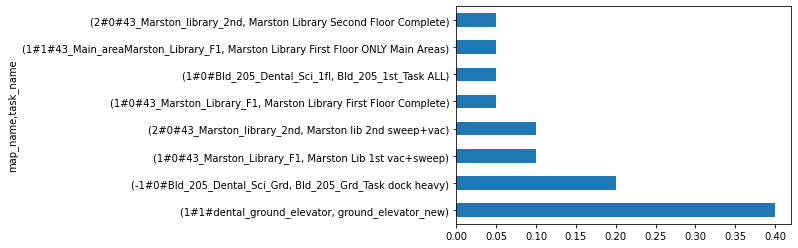

In [26]:
low_efficiency_df[['map_name', 'task_name']].value_counts(normalize=True).plot(kind='barh')

In [27]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


# Get unique maps and sort them
maps = sorted(df['map_name'].unique())

# Option 1: Single plot with all maps (good for smaller number of maps)
if len(maps) <= 10:
    fig = px.line(
        df,
        x="start_time",
        y="efficiency",
        color="map_name",
        markers=True,
        title="Efficiency over Time by Map (Pudu Specifications: Cleaning Efficiency: 700～1,000㎡/h)",
        hover_data=['robot_sn', 'task_name']
    )

    fig.add_hline(
        y=500,
        line_dash="dash",
        line_color="red",
        annotation_text="Efficiency Threshold (500)",
        annotation_position="bottom right"
    )

    fig.update_layout(
        xaxis_title="Task Time",
        yaxis_title="Efficiency (m²/h)",
        legend_title="Map Name",
        hovermode="x unified"
    )

    fig.show()

# Option 2: Subplots for each map (better for many maps)
else:
    n = len(maps)
    cols = 2
    rows = (n + cols - 1) // cols  # Ceiling division

    fig = make_subplots(
        rows=rows,
        cols=cols,
        subplot_titles=[f"Map: {map_name}" for map_name in maps],
        shared_xaxes=True,
        shared_yaxes=True,
        vertical_spacing=0.08,
        horizontal_spacing=0.06
    )

    for i, map_name in enumerate(maps, start=1):
        map_df = df[df['map_name'] == map_name].sort_values('start_time')
        row = (i - 1) // cols + 1
        col = (i - 1) % cols + 1

        # Add efficiency line for this map
        fig.add_trace(
            go.Scatter(
                x=map_df['start_time'],
                y=map_df['efficiency'],
                mode='lines+markers',
                name=map_name,
                legendgroup=map_name,
                showlegend=False,  # Don't show legend in subplots
                hovertemplate='<b>%{x}</b><br>' +
                             f'Map: {map_name}<br>' +
                             'Efficiency: %{y:.1f} m²/h<br>' +
                             'Robot: %{customdata[0]}<br>' +
                             'Task: %{customdata[1]}<extra></extra>',
                customdata=map_df[['robot_sn', 'task_name']].values
            ),
            row=row, col=col
        )

        # Add threshold line for each subplot
        fig.add_hline(
            y=500,
            line_dash="dash",
            line_color="red",
            row=row, col=col
        )

    fig.update_layout(
        height=300 * rows,
        title_text="Efficiency over Time by Map (Pudu Specifications: Cleaning Efficiency: 700～1,000㎡/h)",
        showlegend=False,
        hovermode="x unified"
    )

    fig.update_xaxes(title_text="Task Time")
    fig.update_yaxes(title_text="Efficiency (m²/h)")

    fig.show()

# Additional: Show statistics for each map
print("Efficiency Statistics by Map:")
print("=" * 80)
map_stats = df.groupby('map_name').agg({
    'efficiency': ['count', 'mean', 'min', 'max', 'std'],
    'robot_sn': 'nunique'
}).round(1)

map_stats.columns = ['Task Count', 'Avg Efficiency', 'Min Efficiency', 'Max Efficiency', 'Std Efficiency', 'Unique Robots']
map_stats['Low Efficiency Tasks'] = df[df['efficiency'] < 500].groupby('map_name').size()
map_stats['Low Efficiency Tasks'] = map_stats['Low Efficiency Tasks'].fillna(0).astype(int)
map_stats['Low Efficiency %'] = (map_stats['Low Efficiency Tasks'] / map_stats['Task Count'] * 100).round(1)

print(map_stats.sort_values('Avg Efficiency', ascending=False))

# Show maps with the most low efficiency tasks
low_eff_by_map = df[df['efficiency'] < 500].groupby('map_name').size().sort_values(ascending=False)
if not low_eff_by_map.empty:
    print("\nMaps with Most Low Efficiency Tasks (<500):")
    print("=" * 50)
    for map_name, count in low_eff_by_map.head(10).items():
        total_tasks = len(df[df['map_name'] == map_name])
        percentage = (count / total_tasks * 100) if total_tasks > 0 else 0
        print(f"  {map_name}: {count} low tasks ({percentage:.1f}% of {total_tasks} total tasks)")

Efficiency Statistics by Map:
                                    Task Count  Avg Efficiency  \
map_name                                                         
5#0#Marston-5th-floor                        1           662.9   
2#0#Bld205-Floor2                            4           637.4   
1#1#43_Main_areaMarston_Library_F1           9           596.0   
-1#0#Bld_205_Dental_Sci_Grd                 13           585.1   
1#0#Bld_205_Dental_Sci_1fl                  11           574.7   
2#0#43_Marston_library_2nd                  15           514.0   
1#0#43_Marston_Library_F1                    5           497.7   
1#1#dental_ground_elevator                   8           386.8   

                                    Min Efficiency  Max Efficiency  \
map_name                                                             
5#0#Marston-5th-floor                        662.9           662.9   
2#0#Bld205-Floor2                            633.5           642.4   
1#1#43_Main_areaMarston_Libra

In [30]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np


# Extract hour from start_time
df['hour'] = df['start_time'].dt.hour

# Calculate average efficiency by map_name and hour
hourly_efficiency = df.groupby(['map_name', 'hour']).agg({
    'efficiency': ['mean', 'count', 'std'],
    'robot_sn': 'nunique'
}).round(2)

# Flatten column names
hourly_efficiency.columns = ['avg_efficiency', 'task_count', 'std_efficiency', 'unique_robots']
hourly_efficiency = hourly_efficiency.reset_index()

# Pivot for heatmap
pivot_data = hourly_efficiency.pivot(index='map_name', columns='hour', values='avg_efficiency')

# Fill missing hours with NaN (will appear as gray in heatmap)
all_hours = range(0, 24)
for hour in all_hours:
    if hour not in pivot_data.columns:
        pivot_data[hour] = np.nan

pivot_data = pivot_data.reindex(columns=sorted(pivot_data.columns))

print("Average Efficiency by Map and Hour:")
print("=" * 80)
print(hourly_efficiency.sort_values(['map_name', 'hour']).to_string(index=False))

# Create heatmap
fig_heatmap = go.Figure(data=go.Heatmap(
    z=pivot_data.values,
    x=pivot_data.columns,
    y=pivot_data.index,
    colorscale='RdYlGn_r',  # Red-Yellow-Green reversed (red = low efficiency)
    zmin=0,
    zmax=1000,
    hoverongaps=False,
    hovertemplate='Map: %{y}<br>Hour: %{x}:00<br>Avg Efficiency: %{z:.1f} m²/h<extra></extra>',
    colorbar=dict(title="Efficiency (m²/h)")
))

fig_heatmap.update_layout(
    title="Average Efficiency by Map and Hour of Day (Red = Low Efficiency)",
    xaxis_title="Hour of Day",
    yaxis_title="Map Name",
    height=400 + len(pivot_data) * 20,
    xaxis=dict(tickvals=list(range(0, 24)), ticktext=[f"{h:02d}:00" for h in range(0, 24)])
)

fig_heatmap.show()

# Create subplots for each map showing hourly efficiency patterns
maps = sorted(df['map_name'].unique())
n = len(maps)
cols = 2
rows = (n + cols - 1) // cols

fig_hourly = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=[f"Map: {map_name}" for map_name in maps],
    shared_xaxes=True,
    shared_yaxes=True,
    vertical_spacing=0.08,
    horizontal_spacing=0.06
)

for i, map_name in enumerate(maps, start=1):
    map_hourly = hourly_efficiency[hourly_efficiency['map_name'] == map_name].sort_values('hour')
    row = (i - 1) // cols + 1
    col = (i - 1) % cols + 1

    # Add bar chart for hourly efficiency
    fig_hourly.add_trace(
        go.Bar(
            x=map_hourly['hour'],
            y=map_hourly['avg_efficiency'],
            name=map_name,
            showlegend=False,
            hovertemplate='Hour: %{x}:00<br>Avg Efficiency: %{y:.1f} m²/h<br>' +
                         'Tasks: %{customdata}<br>' +
                         'Robots: %{text}<extra></extra>',
            customdata=map_hourly['task_count'],
            text=map_hourly['unique_robots'],
            marker_color='lightblue',
            marker_line=dict(color='darkblue', width=1)
        ),
        row=row, col=col
    )

    # Add threshold line
    fig_hourly.add_hline(
        y=500,
        line_dash="dash",
        line_color="red",
        annotation_text="500",
        annotation_font_size=10,
        row=row, col=col
    )

fig_hourly.update_layout(
    height=300 * rows,
    title_text="Hourly Average Efficiency by Map",
    showlegend=False,
    bargap=0.1
)

fig_hourly.update_xaxes(title_text="Hour of Day", tickvals=list(range(0, 24, 2)))
fig_hourly.update_yaxes(title_text="Average Efficiency (m²/h)")

fig_hourly.show()

# Detailed analysis of low efficiency hours
print("\n" + "="*80)
print("LOW EFFICIENCY ANALYSIS BY HOUR:")
print("="*80)

# Identify hours with average efficiency below 500
low_efficiency_hours = hourly_efficiency[hourly_efficiency['avg_efficiency'] < 500]

if not low_efficiency_hours.empty:
    print("\nHours with Average Efficiency < 500:")
    print("-" * 60)
    for _, row in low_efficiency_hours.sort_values(['map_name', 'hour']).iterrows():
        print(f"Map: {row['map_name']:20} | Hour: {row['hour']:2d}:00 | "
              f"Avg Eff: {row['avg_efficiency']:6.1f} | Tasks: {row['task_count']:3d} | "
              f"Robots: {row['unique_robots']}")
else:
    print("No hours found with average efficiency below 500")

# Show worst performing hours for each map
print("\nWorst Performing Hours for Each Map:")
print("-" * 60)
for map_name in maps:
    map_data = hourly_efficiency[hourly_efficiency['map_name'] == map_name]
    if not map_data.empty:
        worst_hour = map_data.loc[map_data['avg_efficiency'].idxmin()]
        best_hour = map_data.loc[map_data['avg_efficiency'].idxmax()]

        print(f"Map: {map_name:20}")
        print(f"  Worst:  Hour {worst_hour['hour']:2d}:00 - {worst_hour['avg_efficiency']:6.1f} m²/h "
              f"({worst_hour['task_count']} tasks)")
        print(f"  Best:   Hour {best_hour['hour']:2d}:00 - {best_hour['avg_efficiency']:6.1f} m²/h "
              f"({best_hour['task_count']} tasks)")
        print(f"  Range:  {worst_hour['avg_efficiency']:.1f} - {best_hour['avg_efficiency']:.1f} m²/h")
        print()

# Additional: Hourly pattern across all maps (aggregated)
print("\nOverall Hourly Efficiency Pattern (All Maps Combined):")
print("-" * 60)
overall_hourly = df.groupby('hour').agg({
    'efficiency': ['mean', 'count', 'std'],
    'map_name': 'nunique',
    'robot_sn': 'nunique'
}).round(2)

overall_hourly.columns = ['avg_efficiency', 'total_tasks', 'std_efficiency', 'unique_maps', 'unique_robots']
overall_hourly = overall_hourly.reset_index()

for _, row in overall_hourly.iterrows():
    status = "LOW" if row['avg_efficiency'] < 500 else "OK"
    print(f"Hour {row['hour']:2d}:00 | Eff: {row['avg_efficiency']:6.1f} | "
          f"Tasks: {row['total_tasks']:4d} | Maps: {row['unique_maps']:2d} | "
          f"Robots: {row['unique_robots']:2d} | {status}")

Average Efficiency by Map and Hour:
                          map_name  hour  avg_efficiency  task_count  std_efficiency  unique_robots
       -1#0#Bld_205_Dental_Sci_Grd     9          673.11           9            8.32              1
       -1#0#Bld_205_Dental_Sci_Grd    11          392.71           1             NaN              1
       -1#0#Bld_205_Dental_Sci_Grd    12          368.62           1             NaN              1
       -1#0#Bld_205_Dental_Sci_Grd    13          396.83           1             NaN              1
       -1#0#Bld_205_Dental_Sci_Grd    14          390.28           1             NaN              1
         1#0#43_Marston_Library_F1    12          502.56           2           27.37              1
         1#0#43_Marston_Library_F1    14          573.38           1             NaN              1
         1#0#43_Marston_Library_F1    15          460.53           1             NaN              1
         1#0#43_Marston_Library_F1    22          449.67        


LOW EFFICIENCY ANALYSIS BY HOUR:

Hours with Average Efficiency < 500:
------------------------------------------------------------
Map: -1#0#Bld_205_Dental_Sci_Grd | Hour: 11:00 | Avg Eff:  392.7 | Tasks:   1 | Robots: 1
Map: -1#0#Bld_205_Dental_Sci_Grd | Hour: 12:00 | Avg Eff:  368.6 | Tasks:   1 | Robots: 1
Map: -1#0#Bld_205_Dental_Sci_Grd | Hour: 13:00 | Avg Eff:  396.8 | Tasks:   1 | Robots: 1
Map: -1#0#Bld_205_Dental_Sci_Grd | Hour: 14:00 | Avg Eff:  390.3 | Tasks:   1 | Robots: 1
Map: 1#0#43_Marston_Library_F1 | Hour: 15:00 | Avg Eff:  460.5 | Tasks:   1 | Robots: 1
Map: 1#0#43_Marston_Library_F1 | Hour: 22:00 | Avg Eff:  449.7 | Tasks:   1 | Robots: 1
Map: 1#0#Bld_205_Dental_Sci_1fl | Hour:  7:00 | Avg Eff:  493.3 | Tasks:   1 | Robots: 1
Map: 1#1#43_Main_areaMarston_Library_F1 | Hour: 13:00 | Avg Eff:  479.4 | Tasks:   1 | Robots: 1
Map: 1#1#dental_ground_elevator | Hour: 11:00 | Avg Eff:  382.2 | Tasks:   5 | Robots: 1
Map: 1#1#dental_ground_elevator | Hour: 12:00 | Avg Eff:

ValueError: Unknown format code 'd' for object of type 'float'

In [39]:
df = table.query_data_as_df("SELECT robot_sn, map_name, task_name, start_time, efficiency, status, progress FROM mnt_robots_task WHERE  start_time >= '2025-09-01 00:00:00'")


/Users/jiaxuchen/Foxx/Monitor/pudu_robot/src/pudu/rds/utils.py:296: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [34]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Filter for non-"Task Ended" statuses
non_ended_df = df[df['status'] != 'Task Ended'].copy()

if non_ended_df.empty:
    print("No tasks found with status other than 'Task Ended'")
else:
    # Convert to datetime and extract day of week
    non_ended_df['start_time'] = pd.to_datetime(non_ended_df['start_time'])
    non_ended_df['day_of_week'] = non_ended_df['start_time'].dt.day_name()
    non_ended_df['day_number'] = non_ended_df['start_time'].dt.dayofweek  # Monday=0, Sunday=6

    # Order days properly
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    non_ended_df['day_of_week'] = pd.Categorical(non_ended_df['day_of_week'], categories=day_order, ordered=True)

    # Get unique statuses
    non_ended_statuses = non_ended_df['status'].unique()

    print("Non-'Task Ended' Status Analysis by Day of Week:")
    print("=" * 80)
    print(f"Total non-'Task Ended' tasks: {len(non_ended_df)}")
    print(f"Unique statuses: {list(non_ended_statuses)}")
    print()

    # Calculate counts by status and day of week
    status_day_counts = non_ended_df.groupby(['status', 'day_of_week']).size().reset_index(name='count')

    # Pivot for heatmap
    pivot_data = status_day_counts.pivot(index='status', columns='day_of_week', values='count').fillna(0)

    # Ensure all days are present
    for day in day_order:
        if day not in pivot_data.columns:
            pivot_data[day] = 0

    pivot_data = pivot_data[day_order]  # Reorder columns

    # Create heatmap
    fig_heatmap = go.Figure(data=go.Heatmap(
        z=pivot_data.values,
        x=pivot_data.columns,
        y=pivot_data.index,
        colorscale='Reds',
        hoverongaps=False,
        hovertemplate='Status: %{y}<br>Day: %{x}<br>Count: %{z}<extra></extra>',
        colorbar=dict(title="Task Count")
    ))

    fig_heatmap.update_layout(
        title="Non-'Task Ended' Tasks by Status and Day of Week",
        xaxis_title="Day of Week",
        yaxis_title="Status",
        height=400 + len(pivot_data) * 30
    )

    fig_heatmap.show()

    # Show detailed statistics
    print("Detailed Breakdown by Status and Day:")
    print("-" * 60)

    for status in non_ended_statuses:
        status_data = non_ended_df[non_ended_df['status'] == status]
        status_day_count = status_data.groupby('day_of_week').size()

        print(f"\nStatus: {status}")
        print(f"Total tasks: {len(status_data)}")

        if not status_day_count.empty:
            most_common_day = status_day_count.idxmax()
            most_common_count = status_day_count.max()
            least_common_day = status_day_count.idxmin()
            least_common_count = status_day_count.min()

            print(f"Most common day: {most_common_day} ({most_common_count} tasks)")
            print(f"Least common day: {least_common_day} ({least_common_count} tasks)")

            # Show counts for all days
            for day in day_order:
                count = status_day_count.get(day, 0)
                percentage = (count / len(status_data)) * 100 if len(status_data) > 0 else 0
                print(f"  {day}: {count:2d} tasks ({percentage:5.1f}%)")

    # Create subplots for each status
    n = len(non_ended_statuses)
    cols = 2
    rows = (n + cols - 1) // cols

    fig_bars = make_subplots(
        rows=rows,
        cols=cols,
        subplot_titles=[f"Status: {status}" for status in non_ended_statuses],
        shared_xaxes=True,
        shared_yaxes=False,
        vertical_spacing=0.1,
        horizontal_spacing=0.08
    )

    for i, status in enumerate(non_ended_statuses, start=1):
        status_data = non_ended_df[non_ended_df['status'] == status]
        day_counts = status_data.groupby('day_of_week').size().reindex(day_order, fill_value=0)

        row = (i - 1) // cols + 1
        col = (i - 1) % cols + 1

        fig_bars.add_trace(
            go.Bar(
                x=day_counts.index,
                y=day_counts.values,
                name=status,
                showlegend=False,
                hovertemplate='Day: %{x}<br>Count: %{y}<br>Status: ' + status + '<extra></extra>',
                marker_color='lightcoral',
                marker_line=dict(color='darkred', width=1)
            ),
            row=row, col=col
        )

        # Add percentage annotations
        total_tasks = len(status_data)
        if total_tasks > 0:
            for j, (day, count) in enumerate(zip(day_counts.index, day_counts.values)):
                percentage = (count / total_tasks) * 100
                if count > 0:  # Only show annotation if there are tasks
                    fig_bars.add_annotation(
                        x=day, y=count,
                        text=f"{percentage:.0f}%",
                        showarrow=False,
                        yshift=10,
                        row=row, col=col
                    )

    fig_bars.update_layout(
        height=300 * rows,
        title_text="Distribution of Non-'Task Ended' Tasks by Day of Week",
        showlegend=False,
        bargap=0.3
    )

    fig_bars.update_xaxes(tickangle=45)
    fig_bars.update_yaxes(title_text="Task Count")

    fig_bars.show()


Non-'Task Ended' Status Analysis by Day of Week:
Total non-'Task Ended' tasks: 31
Unique statuses: ['Task Interrupted', 'Task Cancelled', 'Task Abnormal']



Detailed Breakdown by Status and Day:
------------------------------------------------------------

Status: Task Interrupted
Total tasks: 3
Most common day: Friday (2 tasks)
Least common day: Monday (0 tasks)
  Monday:  0 tasks (  0.0%)
  Tuesday:  0 tasks (  0.0%)
  Wednesday:  1 tasks ( 33.3%)
  Thursday:  0 tasks (  0.0%)
  Friday:  2 tasks ( 66.7%)
  Saturday:  0 tasks (  0.0%)
  Sunday:  0 tasks (  0.0%)

Status: Task Cancelled
Total tasks: 19
Most common day: Monday (4 tasks)
Least common day: Saturday (0 tasks)
  Monday:  4 tasks ( 21.1%)
  Tuesday:  4 tasks ( 21.1%)
  Wednesday:  2 tasks ( 10.5%)
  Thursday:  3 tasks ( 15.8%)
  Friday:  4 tasks ( 21.1%)
  Saturday:  0 tasks (  0.0%)
  Sunday:  2 tasks ( 10.5%)

Status: Task Abnormal
Total tasks: 9
Most common day: Monday (2 tasks)
Least common day: Saturday (0 tasks)
  Monday:  2 tasks ( 22.2%)
  Tuesday:  2 tasks ( 22.2%)
  Wednesday:  2 tasks ( 22.2%)
  Thursday:  2 tasks ( 22.2%)
  Friday:  1 tasks ( 11.1%)
  Saturday:  0 ta

In [42]:
df

,robot_sn,map_name,task_name,start_time,efficiency,status,progress
0,811135422060228,1#0#43_Marston_Library_F1,Marston Lib 1st vac+sweep,2025-09-01 12:06:49,483.21,Task Ended,100.0
1,811135422060228,1#0#43_Marston_Library_F1,Marston Lib 1st vac+sweep,2025-09-01 22:56:59,449.67,Task Ended,100.0
2,811135422060228,2#0#43_Marston_library_2nd,Marston lib 2nd sweep+vac,2025-09-02 09:18:01,516.04,Task Ended,100.0
3,811135422060216,-1#0#Bld_205_Dental_Sci_Grd,Bld_205_Grd_Task ALL,2025-09-02 09:47:43,670.16,Task Ended,100.0
4,811135422060228,1#1#43_Main_areaMarston_Library_F1,Marston Main Areas Clean,2025-09-02 12:52:06,544.34,Task Ended,100.0
...,...,...,...,...,...,...,...
92,811135422060228,1#1#43_Main_areaMarston_Library_F1,Marston Library First Floor ONLY Main Areas,2025-09-30 13:31:17,479.44,Task Ended,100.0
93,811135422060216,1#0#Bld_205_Dental_Sci_1fl,Bld_205_1st_Task ALL,2025-09-30 21:09:08,605.15,Task Cancelled,75.0
94,811135422060216,1#0#Bld_205_Dental_Sci_1fl,Bld_205_1st_Task ALL,2025-10-01 07:00:29,0.00,Task Abnormal,100.0
95,811135422060216,1#0#Bld_205_Dental_Sci_1fl,Bld_205_1st_Task ALL,2025-10-01 09:22:55,0.00,Task Cancelled,0.0


In [44]:
# Group by task_name and status to see start times AND progress
task_status_data = df.groupby(['task_name', 'status']).agg({
    'start_time': list,
    'progress': list
}).reset_index()

# Display the results
for robot_sn in df['robot_sn'].unique():
    df_temp = df[df['robot_sn'] == robot_sn]
    print(f"Robot: {robot_sn}")
    for task_name in df_temp['task_name'].unique():
        task_data = task_status_data[task_status_data['task_name'] == task_name]
        if len(task_data) > 1:  # Only show tasks with multiple statuses
            print(f"\nTask: {task_name}")
            print("-" * 50)
            for _, row in task_data.iterrows():
                status = row['status']
                start_times = row['start_time']
                progress_values = row['progress']
                print(f"  Status: {status}")
                for time, progress in zip(start_times, progress_values):
                    print(f"    - {time} | Progress: {progress}")

Robot: 811135422060228

Task: Marston Lib 1st vac+sweep
--------------------------------------------------
  Status: Task Cancelled
    - 2025-09-07 23:02:14 | Progress: 4.0
  Status: Task Ended
    - 2025-09-01 12:06:49 | Progress: 100.0
    - 2025-09-01 22:56:59 | Progress: 100.0
    - 2025-09-05 12:25:32 | Progress: 100.0

Task: Marston lib 2nd sweep+vac
--------------------------------------------------
  Status: Task Cancelled
    - 2025-09-04 12:40:05 | Progress: 0.0
  Status: Task Ended
    - 2025-09-02 09:18:01 | Progress: 100.0
    - 2025-09-03 09:27:20 | Progress: 100.0
    - 2025-09-04 09:33:29 | Progress: 100.0
    - 2025-09-05 09:22:21 | Progress: 100.0
    - 2025-09-06 13:45:24 | Progress: 100.0
    - 2025-09-07 12:25:23 | Progress: 100.0
    - 2025-09-09 09:24:43 | Progress: 100.0
    - 2025-09-10 09:34:40 | Progress: 100.0

Task: Marston Main Areas Clean
--------------------------------------------------
  Status: Task Cancelled
    - 2025-09-10 14:14:30 | Progress: 66.

In [46]:
df[df['task_name'] == 'Bld_205_1st_Task ALL'].sort_values('start_time')

,robot_sn,map_name,task_name,start_time,efficiency,status,progress
5,811135422060216,1#0#Bld_205_Dental_Sci_1fl,Bld_205_1st_Task ALL,2025-09-02 21:11:06,601.62,Task Ended,100.0
12,811135422060216,1#0#Bld_205_Dental_Sci_1fl,Bld_205_1st_Task ALL,2025-09-03 21:11:42,600.47,Task Ended,100.0
26,811135422060216,1#0#Bld_205_Dental_Sci_1fl,Bld_205_1st_Task ALL,2025-09-05 21:11:57,600.73,Task Ended,100.0
38,811135422060216,1#0#Bld_205_Dental_Sci_1fl,Bld_205_1st_Task ALL,2025-09-09 12:24:33,490.85,Task Cancelled,2.0
39,811135422060216,1#0#Bld_205_Dental_Sci_1fl,Bld_205_1st_Task ALL,2025-09-09 12:32:33,546.24,Task Ended,100.0
62,811135422060216,1#0#Bld_205_Dental_Sci_1fl,Bld_205_1st_Task ALL,2025-09-18 02:43:39,576.31,Task Ended,100.0
61,811135422060216,1#0#Bld_205_Dental_Sci_1fl,Bld_205_1st_Task ALL,2025-09-18 09:26:01,571.41,Task Ended,100.0
58,811135422060216,1#0#Bld_205_Dental_Sci_1fl,Bld_205_1st_Task ALL,2025-09-18 14:00:25,0.00,Task Cancelled,0.0
57,811135422060216,1#0#Bld_205_Dental_Sci_1fl,Bld_205_1st_Task ALL,2025-09-18 21:54:56,603.29,Task Ended,100.0
56,811135422060216,1#0#Bld_205_Dental_Sci_1fl,Bld_205_1st_Task ALL,2025-09-19 07:00:29,493.29,Task Ended,100.0


In [48]:
# Add day of week to the dataframe
df_temp = df[df['task_name'] == 'Bld_205_1st_Task ALL'].copy()
df_temp['day_of_week'] = df_temp['start_time'].dt.day_name()
df_temp['date'] = df_temp['start_time'].dt.date

# Sort by start_time and display
result = df_temp.sort_values('start_time')

print("Task: Bld_205_1st_Task ALL")
print("=" * 80)
print(f"{'Start Time':20} | {'Day of Week':12} | {'Status':15} | {'Progress':8} | {'Robot SN'}")
print("-" * 80)

for _, row in result.iterrows():
    print(f"{row['start_time']} | {row['day_of_week']:12} | {row['status']:15} | {row['progress']:8} | {row['robot_sn']}")

Task: Bld_205_1st_Task ALL
Start Time           | Day of Week  | Status          | Progress | Robot SN
--------------------------------------------------------------------------------
2025-09-02 21:11:06 | Tuesday      | Task Ended      |    100.0 | 811135422060216
2025-09-03 21:11:42 | Wednesday    | Task Ended      |    100.0 | 811135422060216
2025-09-05 21:11:57 | Friday       | Task Ended      |    100.0 | 811135422060216
2025-09-09 12:24:33 | Tuesday      | Task Cancelled  |      2.0 | 811135422060216
2025-09-09 12:32:33 | Tuesday      | Task Ended      |    100.0 | 811135422060216
2025-09-18 02:43:39 | Thursday     | Task Ended      |    100.0 | 811135422060216
2025-09-18 09:26:01 | Thursday     | Task Ended      |    100.0 | 811135422060216
2025-09-18 14:00:25 | Thursday     | Task Cancelled  |      0.0 | 811135422060216
2025-09-18 21:54:56 | Thursday     | Task Ended      |    100.0 | 811135422060216
2025-09-19 07:00:29 | Friday       | Task Ended      |    100.0 | 811135422060

In [50]:
df_temp.groupby('day_of_week')['status'].value_counts()

day_of_week  status        
Friday       Task Ended        2
             Task Cancelled    1
Monday       Task Abnormal     1
             Task Cancelled    1
Thursday     Task Ended        5
             Task Cancelled    2
             Task Abnormal     1
Tuesday      Task Ended        3
             Task Cancelled    2
             Task Abnormal     1
Wednesday    Task Abnormal     2
             Task Cancelled    1
             Task Ended        1
Name: count, dtype: int64

In [8]:
df = table.query_data_as_df("SELECT robot_sn, start_time, status FROM mnt_robots_task")
df.head(1)

/Users/jiaxuchen/Foxx/Monitor/pudu_robot/src/pudu/rds/utils.py:296: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,robot_sn,start_time,status
0,811135422060216,2025-08-14 22:03:08,Task Cancelled


In [9]:
df.columns

Index(['robot_sn', 'start_time', 'status'], dtype='object')

In [10]:
import plotly.express as px

# Count statuses per robot
status_counts = df.groupby(["robot_sn", "status"]).size().reset_index(name="count")

# Compute percentage per robot (aligned with index)
status_counts["percent"] = (
    status_counts["count"] / status_counts.groupby("robot_sn")["count"].transform("sum") * 100
)

# Round and format percentages for labels
status_counts["percent_label"] = status_counts["percent"].round(1).astype(str) + "%"

fig = px.bar(
    status_counts,
    x="robot_sn",
    y="count",
    color="status",
    barmode="group",
    text="percent_label",
    title="Task Status Count per Robot (with %)"
)

fig.update_layout(
    xaxis_title="Robot SN",
    yaxis_title="Task Count",
    legend_title="Status"
)

fig.show()

In [13]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# --- prepare data ---
df['start_time'] = pd.to_datetime(df['start_time'])
df['week_start'] = df['start_time'].dt.to_period("W").apply(lambda p: p.start_time)

# Get all possible weeks, robots, and statuses for complete combination
all_weeks = df['week_start'].unique()
all_robots = df['robot_sn'].unique()
all_statuses = df['status'].unique()

# Create a complete index with all combinations
import itertools
complete_index = pd.MultiIndex.from_product(
    [all_weeks, all_robots, all_statuses],
    names=['week_start', 'robot_sn', 'status']
)

# First, get total tasks per robot per week
weekly_totals = (
    df.groupby(['week_start', 'robot_sn'])
      .size()
      .reset_index(name='total_count')
)

# Then get counts by status
task_weekly = (
    df.groupby(['week_start', 'robot_sn', 'status'])
      .size()
      .reset_index(name='count')
)

# Reindex to include all combinations and fill missing values with 0
task_weekly_complete = (
    task_weekly.set_index(['week_start', 'robot_sn', 'status'])
    .reindex(complete_index, fill_value=0)
    .reset_index()
)

# Merge to calculate percentages
task_weekly_complete = task_weekly_complete.merge(
    weekly_totals,
    on=['week_start', 'robot_sn'],
    how='left'
)

# Fill NaN total_count with 0 (for weeks with no tasks at all for a robot)
task_weekly_complete['total_count'] = task_weekly_complete['total_count'].fillna(0)

# Calculate percentage - handle division by zero
task_weekly_complete['percentage'] = (
    task_weekly_complete['count'] /
    task_weekly_complete['total_count'].replace(0, 1) * 100  # Avoid division by zero
)
# Where total_count is 0, set percentage to 0
task_weekly_complete.loc[task_weekly_complete['total_count'] == 0, 'percentage'] = 0

robots = sorted(task_weekly_complete['robot_sn'].unique(), key=lambda x: str(x))
statuses = list(task_weekly_complete['status'].unique())

# --- assign fixed colors (so same status always same color) ---
color_map = {
    status: color for status, color in zip(
        statuses,
        px.colors.qualitative.Plotly  # or use another palette
    )
}

# --- create subplots ---
n = len(robots)
fig = make_subplots(
    rows=n,
    cols=1,
    shared_xaxes=True,
    shared_yaxes=True,
    vertical_spacing=0.1,
    subplot_titles=[f"Robot {r}" for r in robots]
)

# Add traces
for i, robot in enumerate(robots, start=1):
    robot_df = task_weekly_complete[task_weekly_complete['robot_sn'] == robot].sort_values('week_start')
    for status in statuses:
        s_df = robot_df[robot_df['status'] == status].sort_values('week_start')
        if s_df.empty:
            continue
        fig.add_trace(
            go.Scatter(
                x=s_df['week_start'],
                y=s_df['percentage'],
                mode='lines+markers',
                name=status,
                legendgroup=status,        # 🔹 unify legend across subplots
                line=dict(color=color_map[status]),
                showlegend=(i == 1),       # 🔹 only show legend once (top)
                hovertemplate='<b>%{x}</b><br>' +
                             f'Status: {status}<br>' +
                             'Percentage: %{y:.1f}%<br>' +
                             'Count: %{customdata}<br>' +
                             'Total Tasks: %{text}<extra></extra>',
                customdata=s_df['count'],  # Show raw count in hover
                text=s_df['total_count']   # Show total tasks in hover
            ),
            row=i, col=1
        )

# Layout
fig.update_layout(
    height=max(600, 240 * n),
    title_text="Weekly Task Percentage per Robot — weekly percentage of tasks by status (one subplot per robot)",
    hovermode='x unified',
    legend_title_text='Status'
)

# unify y and x axis labels
fig.update_yaxes(title_text='Task Percentage (%)', range=[0, 100])  # Set fixed range for percentage
fig.update_xaxes(title_text='Week Start', row=n, col=1)
fig.update_xaxes(tickformat='%b %d\n%Y')

fig.show()

In [ ]:
data_list = df.drop(columns=['id']).to_dict(orient='records')
data_list_new = data_list.copy()[0]
data_list_new['task_namess'] = '123'
data_list_new['task_name'] = 'mode1'
changes = detect_data_changes(table, [data_list_new], table.primary_keys)
changes

In [ ]:
get_robot_details('811135422060216')

In [ ]:
get_robot_details('811135422060228')

In [ ]:
df = get_schedule_table(start_time='2025-08-11 00:00:00', end_time='2025-08-18 23:59:59')
df

In [ ]:
results = get_cleaning_report_list(start_time='2025-08-11 00:00:00', end_time='2025-08-18 23:59:59', shop_id='533370001',
                                           timezone_offset=0)['list']
results

In [ ]:
df = get_schedule_table(start_time='2025-08-11 00:00:00', end_time='2025-08-18 23:59:59')
df

In [ ]:
# Get configuration file path - try multiple locations
import os
config_paths = [
    'database_config.yaml',
    '../src/pudu/configs/database_config.yaml',
    'src/pudu/configs/database_config.yaml',
    'pudu/configs/database_config.yaml',
    '/opt/database_config.yaml'
]

config_path = None
for path in config_paths:
    if os.path.exists(path):
        config_path = path
        break

In [ ]:
app = App(config_path)

In [ ]:
start_time_str = '2025-08-11 00:00:00'
end_time_str = '2025-08-18 23:59:59'

success = app.run(start_time=start_time_str, end_time=end_time_str)

In [ ]:
df = get_ongoing_tasks_table()

In [ ]:
df.columns

In [ ]:
df.to_dict(orient='records')

In [ ]:
df.to_dict(orient='records')

In [ ]:
get_robot_details('8110H4802050005')

In [ ]:
pd.to_datetime(1747273785400, unit='ms')

In [ ]:
get_robot_details('8110H4802050005')

In [ ]:
pd.to_datetime(1755249066, unit='s')

In [ ]:
df = get_schedule_table(start_time='2025-08-11 00:00:00', end_time='2025-08-18 23:59:59')
df

In [ ]:
get_cleaning_report_list(start_time='2025-08-16 00:00:00', end_time='2025-08-17 23:59:59', shop_id='450270000', sn='8110H4802050005')

In [ ]:
import timezone

In [ ]:
data = get_cleaning_report_list(start_time='2025-08-13 00:00:00', end_time='2025-08-13 23:59:59', shop_id='533370001', sn='811135422060228')['list']
# convert to datetime
for i in data:
    if i['report_id'] == '1153161039358726144':
        start_time = pd.to_datetime(i['start_time'], unit='s').tz_localize('UTC').tz_convert('US/Eastern')
        end_time = pd.to_datetime(i['end_time'], unit='s').tz_localize('UTC').tz_convert('US/Eastern')
        clean_time = round(i['clean_time'] / 3600, 2)
        print("Report ID: {}; Report start time: {}; Report end time: {}; end_time - start_time: {}; Report's clean_time: {}h;".format(i['report_id'],start_time.strftime('%Y-%m-%d %H:%M:%S'), end_time.strftime('%Y-%m-%d %H:%M:%S'), end_time - start_time, clean_time))
        break

In [ ]:

start_time = "2025-08-12 00:00:00"
end_time = "2025-08-15 23:59:59"
charging_table = get_battery_health_list(start_time, end_time, shop_id='533370001')

In [ ]:
import time
int(time.time())

In [ ]:
get_list_stores()['list']

In [ ]:
get_list_robots(shop_id='533370001')

In [ ]:
get_cleaning_report_list(start_time='2025-08-15 00:00:00', end_time='2025-08-15 23:59:59', shop_id='533370001', sn='811135422060216')

In [ ]:
int(time.time())

curl -X POST "http://3.142.93.105:8000/api/pudu/webhook" -H "Content-Type: application/json" -H "CallbackCode: 1vQ6MfUxqyoGMRQ9nK8C4pSkg1Qsa3Vpq" -d '{"callback_type": "notifyRobotPose", "data": {"sn": "811135422060216", "timestamp": 1756248555, "x":1.234, "y":2.345, "yaw":32.34}}'

curl -X POST "http://44.193.26.65:8000/api/pudu/webhook" -H "Content-Type: application/json" -H "CallbackCode: 1vQ6MfUxqyoGMRQ9nK8C4pSkg1Qsa3Vpq" -d '{"callback_type": "robotErrorWarning", "data": {"sn": "811064412050012", "timestamp": 1755387517, "error_type": "LostLocalization", "error_level": "Warning", "error_detail": "",  "error_id": "test00003"}}'

curl -X GET "http://18.222.168.242:8000/api/pudu/webhook/health"

curl -X GET "http://3.142.93.105:8000/api/pudu/webhook/health"

import time

In [ ]:
for result in charging_table['list']:
    print(result['sn'], result['work_status'])

In [ ]:
sns = set()
for result in charging_table['list']:
    sns.add(result['sn'])
sns

In [ ]:
battery_health_dict = {}
sn = set()
for health_record in charging_table['list']:
    key = health_record['sn']
    sn.add(key)
    battery_health_dict[key] = {
        'cycle': health_record.get('cycle', None),
        'soc': health_record.get('soc', None),
        'soh': health_record.get('soh', None)
    }

In [ ]:
get_list_robots(shop_id='533370001')['list']

In [ ]:
sn

In [ ]:
results = get_charging_record_list(start_time, end_time, shop_id='533370001', timezone_offset=0)['list']

In [ ]:
sns = set()
for result in results:
    sns.add(result['sn'])
sns

In [ ]:
s = get_charging_table(start_time, end_time, location_id='533370001')
s